#**HUMAN RIGHTS PROTECTION ANALYSIS**

## Quick Overview

This notebook investigates how climate disaster events affect fundamental human rights across countries and regions between 2000 and 2023. Using disaster subtype mappings linked to specific rights (e.g., life, shelter, aid, health), it constructs a Rights Impact dataset from EM-DAT and preparedness classifications. The analysis visualizes and quantifies how different types of disasters disproportionately affect human rights in certain subregions and countries, even when preparedness levels are high. Through heatmaps, country comparisons, and regional breakdowns, the notebook offers data-driven insight into how effectively states are protecting rights in disaster contexts.

A detailed methodology and full findings summary is provided at the end.

**Research Question:**

"How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?"



##**Importing Libraries for Human Rights and Preparedness Analysis**


In [1]:
# Core libraries for data manipulation and visualization
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
!pip install prophet
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
!pip install -U kaleido
import statsmodels.api as sm
import statsmodels.formula.api as smf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.8 MB/s eta 0:00:00


## **Importing Libraries for Data Analysis and Visualization**

In [2]:
# For modeling and statistical analysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

**Description:**

This block imports the essential Python libraries used for analyzing and visualizing data in this phase of the thesis. **pandas** and **numpy** are used for data handling and transformation, while **matplotlib**, **seaborn**, and **plotly** are used to generate both static and interactive plots for exploratory and explanatory analysis.

**Connection to Research Question:**

These tools provide the analytical foundation for exploring **how well human rights are protected during climate disasters**. They enable the visualization of patterns and relationships between **state preparedness** and **rights protection indicators**, helping to assess disparities and evaluate which conditions lead to stronger or weaker protection of fundamental rights.

## **Loading Datasets**

In [3]:
# Load all three datasets into distinct DataFrames
df_full = pd.read_csv("emdat_wgi_rights.csv")                         # raw full dataset
df_prepared = pd.read_csv("phase1_disaster_data_with_preparedness.csv")  # event-level w/ preparedness
df_index = pd.read_csv("preparedness_index_by_country.csv")          # country-level index

## **Log-Transformation of Count-Based Disaster Variables**

In [4]:
# List of variables to log-transform
log_vars = [
    'Num_Disasters',
    'Total_Deaths',
    'Total_Injured',
    'Total_Affected',
    'Total_Homeless',
    'Combined_Affected',
    'Total_Damage_USD',
    'Num_OFDA_BHA_Response',
    'Num_Appeals',
    'Num_Declarations'
]

# Apply log1p (log(1 + x)) to safely overwrite in both df_full and df_prepared
for df in [df_full, df_prepared]:
    for col in log_vars:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: np.log1p(x))

# Confirmation message
print("✔️ Log transformation applied directly to the following columns (in-place):")
print(log_vars)

✔️ Log transformation applied directly to the following columns (in-place):
['Num_Disasters', 'Total_Deaths', 'Total_Injured', 'Total_Affected', 'Total_Homeless', 'Combined_Affected', 'Total_Damage_USD', 'Num_OFDA_BHA_Response', 'Num_Appeals', 'Num_Declarations']


In [5]:
df_prepared[['Total_Deaths', 'Total_Homeless', 'Total_Injured']].describe()

,Total_Deaths,Total_Homeless,Total_Injured
count,4342.000000,4342.000000,4342.000000
mean,2.146550,1.455002,1.323228
std,2.033551,3.245587,2.267805
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.945910,0.000000,0.000000
75%,3.496508,0.000000,2.397895
max,12.313001,15.424949,12.816960


**Description:**

This section applies a natural **logarithm transformation** to **key count-based variables** that represent the severity of disaster events and the scale of government responses—such as **total deaths, injuries, affected populations, and damage estimates**. Log-transforming these skewed variables ensures that extremely high values (e.g., from large-scale disasters) do not **disproportionately influence analysis**. It also enhances **interpretability**, as changes on the log scale correspond to multiplicative differences (e.g., doubling or halving of values). This transformation makes the data more suitable for **modeling, visualization, and cross-country comparison**, especially when dealing with distributions that span several orders of magnitude.


**Connection to Research Question:**

The log-transformation directly supports the thesis goal of **analyzing human rights risks in climate disaster contexts** by ensuring that key severity indicators are evaluated on a **normalized and comparable scale**. Without this adjustment, extremely large disaster events could disproportionately influence the analysis and obscure patterns in smaller but still impactful crises. By applying the log transformation, the analysis more accurately captures proportional differences in disaster impact—allowing for clearer identification of when and where populations face heightened risks to fundamental rights such as **life, shelter, and access to aid**.

##**Comparing Governance and Human Rights Risk by Preparedness Level**

In [6]:
# Compute the averages
governance_risk_summary = df_prepared.groupby('Preparedness_Level')[['Gov_Effectiveness_Estimate', 'Rights_Risk_Score']].mean().reset_index()

# Save to CSV with the 'Preparedness_Level' column included
governance_risk_summary.to_csv("Gov_vs_Human_Rights_Risk_by_Preparedness.csv", index=False)

governance_risk_summary

,Preparedness_Level,Gov_Effectiveness_Estimate,Rights_Risk_Score
0,Not Prepared,-0.323221,2.902516
1,Prepared,0.003710,2.855616
2,Somewhat Prepared,-0.319763,2.864253


**Description:**

This code calculates the **average values** of two key governance and human rights indicators —
Gov_Effectiveness_Estimate (from the World Governance Indicators) and Rights_Risk_Score (from the human rights dataset) —
**for each disaster preparedness level** in the dataset. By grouping all disaster events by their assigned Preparedness_Level, this analysis highlights how government effectiveness and the risk of human rights violations vary across events where governments were classified as **Prepared**, **Somewhat Prepared**, or **Not Prepared**.

**Interpretation of Results:**

The table shows that:
- Countries classified as **Prepared** tend to have **higher average government effectiveness** (≈ 0.00) and slightly **lower human rights risk scores**.
- In contrast, **Not Prepared** countries have significantly **lower governance effectiveness** scores (≈ -0.33) and slightly **higher rights risk**.
- Interestingly, **Somewhat Prepared** countries exhibit governance scores similar to Not Prepared, suggesting that their responses may still be structurally weak or inconsistent.

This pattern reinforces the idea that **state capacity and institutional quality** play an important role in disaster preparedness and rights protection.

**Connection to Research Question:**

These findings directly support the thesis question by linking **state preparedness** with **governance quality** and **rights outcomes**. Countries with stronger governance appear better equipped to manage disasters while protecting human rights. This validates the use of **data science models** to assess institutional readiness and guide improvements in state capacity for future crises.

## **Visualizing Relationships Between Governance, Damage, Deaths, and Preparedness Levels**

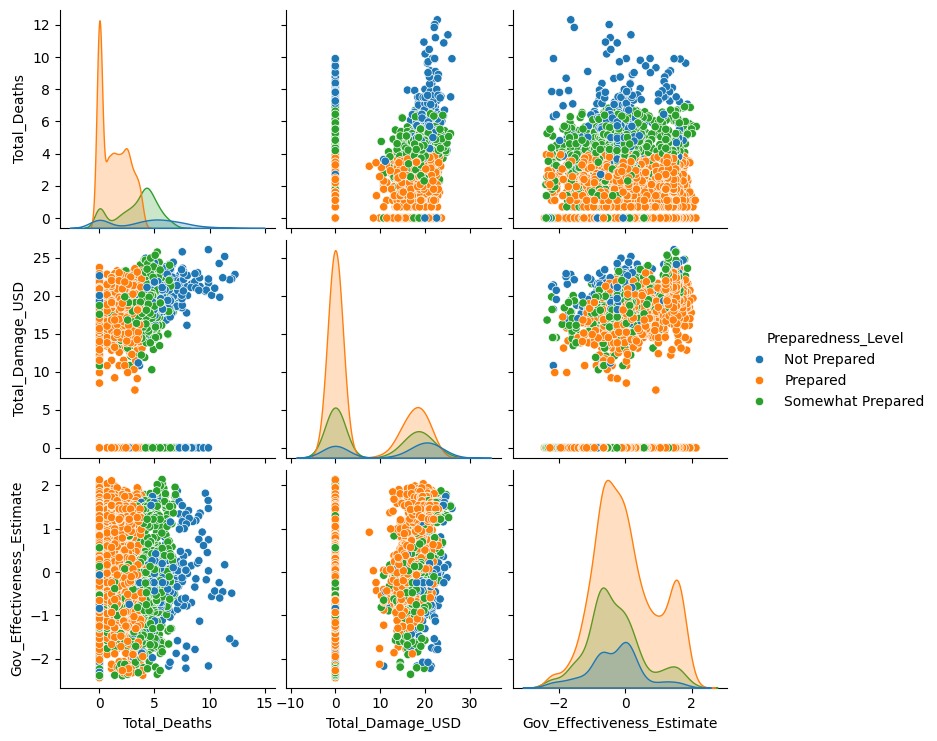

In [7]:
# Create a Seaborn pairplot to explore relationships between disaster severity, governance effectiveness,
# and preparedness classification. Highlights trends in deaths, economic damage, and governance quality
# across preparedness levels.
rel_pairplot = sns.pairplot(df_prepared, hue="Preparedness_Level", vars=["Total_Deaths", "Total_Damage_USD", "Gov_Effectiveness_Estimate"])

# Save figure
rel_pairplot.fig.savefig("Pairplot_Governance_Damage_Deaths.png", dpi=300, bbox_inches='tight')

**Description:**

This **Seaborn pairplot** presents pairwise scatterplots and univariate distributions for Total_Deaths, Total_Damage_USD, and Gov_Effectiveness_Estimate, with each data point color-coded by preparedness classification (Prepared, Somewhat Prepared, Not Prepared). The plot allows for visual comparison across governance quality, disaster severity, and preparedness levels. The diagonal histograms show the distribution of each variable within preparedness groups, while the scatterplots below illustrate how these indicators relate to each other across different state responses.

**Interpretation of Results:**

The pairplot reveals distinct patterns across preparedness categories. Events classified as **“Not Prepared”** tend to align with lower governance effectiveness and higher values of disaster impact, though the spread now shows a range of severity levels. This suggests that lack of preparedness is not limited to the most extreme events but is also associated with moderately severe disasters. In contrast, **“Prepared”** events are more tightly grouped and align with higher governance scores and lower relative disaster impacts, indicating stronger institutional response. **“Somewhat Prepared”** events occupy a middle ground, spanning a wide range of governance effectiveness and impact severity, suggesting mixed state capacity and varying levels of institutional resilience.

**Connection to Research Question:**

This visualization highlights the relationship between **preparedness, governance quality, and disaster impact severity**, which directly addresses the research question on how effectively states protect human rights in disaster-prone contexts. Strong governance appears linked to both better preparedness and reduced disaster impacts—factors essential for safeguarding rights to life, shelter, and aid. Meanwhile, low-preparedness contexts are associated with weaker governance and greater harm. The visual separation between categories provides preliminary evidence that stronger state institutions are more capable of managing climate-related disasters in a way that upholds fundamental human rights.

# **Creating a Country-Level Preparedness Score**

In [8]:
# Convert preparedness levels to numeric flags (Prepared = 2, Somewhat Prepared = 1, Not Prepared = 0)
df_prepared['Prepared_Flag'] = df_prepared['Preparedness_Level'].map({
    "Prepared": 2,
    "Somewhat Prepared": 1,
    "Not Prepared": 0
})

# Calculate the average preparedness score for each country
score_by_country = df_prepared.groupby("Country")['Prepared_Flag'].mean().sort_values()

**Description:**

This code translates categorical preparedness levels into numeric values to allow averaging across events. It assigns a score of 2 to “Prepared,” 1 to “Somewhat Prepared,” and 0 to “Not Prepared.” By calculating the mean preparedness score per country, it generates a continuous metric that captures how consistently a country tends to respond well to disasters. This score can be used for mapping, correlation with governance indicators, or comparative analysis.

##**Disaster Type vs. Preparedness Patterns**

In [9]:
# Count preparedness levels across disaster types
disaster_prep = df_prepared.groupby(['Disaster Type', 'Preparedness_Level']) \
                           .size().unstack(fill_value=0)

# Calculate the percentage distribution within each disaster type
disaster_prep_percent = disaster_prep.div(disaster_prep.sum(axis=1), axis=0).round(2)

# Display results
display(disaster_prep)
display(disaster_prep_percent)

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Disaster Type,,,
Drought,143,147,101
Earthquake,41,255,90
Extreme temperature,40,84,92
Flood,159,1624,611
Storm,94,608,205
Wildfire,0,42,6


Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Disaster Type,,,
Drought,0.37,0.38,0.26
Earthquake,0.11,0.66,0.23
Extreme temperature,0.19,0.39,0.43
Flood,0.07,0.68,0.26
Storm,0.10,0.67,0.23
Wildfire,0.00,0.88,0.12


In [11]:
# Export the raw counts to CSV
disaster_prep.to_csv("preparedness_counts_by_disaster_type.csv")

# Export the percentage distribution to CSV
disaster_prep_percent.to_csv("preparedness_percent_by_disaster_type.csv")


**Description:**

This code segment analyzes how preparedness levels vary across different disaster types. The first table displays the absolute number of events categorized as **“Prepared,” “Somewhat Prepared,” and “Not Prepared”** for each type of disaster (e.g., floods, droughts, earthquakes). The second table presents the same data in percentage terms, showing the relative frequency of each preparedness level within a disaster category. This allows for both raw comparison and normalized insight into state response across hazard types.

**Interpretation of Results:**

The data reveals that preparedness varies significantly depending on the type of disaster. For example, flood and earthquake events are more frequently classified as “Prepared,” while droughts and extreme temperatures show higher shares of “Not Prepared” or “Somewhat Prepared.” These findings suggest that governments may be more structurally equipped to handle sudden-onset disasters like floods and storms, while slower-onset or less predictable events (e.g., droughts, heatwaves) expose critical gaps in readiness. The variation in percentage scores also highlights where targeted improvements are needed.

**Connection to Research Question:**

This breakdown directly supports the thesis objective of understanding **how different types of climate disasters influence state capacity to uphold human rights**. By analyzing preparedness across hazard categories, we can pinpoint which threats most often overwhelm response systems. This informs the development of more hazard-specific preparedness strategies, ensuring that no rights — such as access to water during droughts or shelter after storms — are disproportionately compromised based on the nature of the disaster.


##**Visualizing Preparedness Proportions by Disaster Type: Evidence of Uneven Risk Protection**

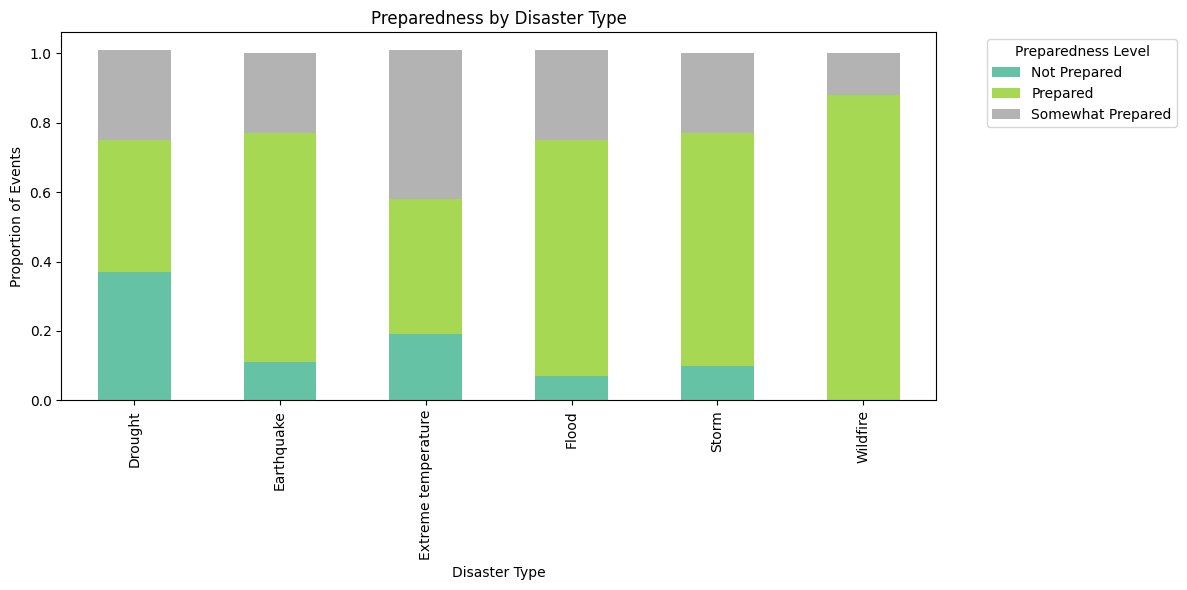

In [12]:
# Plot stacked bar chart of proportions
disaster_prep_percent.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
plt.title("Preparedness by Disaster Type")
plt.ylabel("Proportion of Events")
plt.xlabel("Disaster Type")
plt.legend(title="Preparedness Level", bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Save Figure
plt.savefig("preparedness_proportion_by_disaster_type.png", dpi=300)

plt.show()

**Description:**

This plot visualizes the **proportional distribution of preparedness levels across disaster types** using a stacked bar chart. For each disaster type — including floods, droughts, wildfires, storms, earthquakes, and extreme temperatures — the plot displays the share of events classified as “Prepared,” “Somewhat Prepared,” or “Not Prepared.” The proportions are normalized within each disaster type, allowing for a clear comparison of how different types of hazards are associated with varying levels of state readiness. This setup helps reveal hazard-specific trends in preparedness capacity across the dataset.

**Interpretation of Results:**

The chart reveals that preparedness levels vary noticeably across disaster types. **Floods and storms** are associated with the highest proportions of “Prepared” classifications, while **wildfires** are nearly all labeled “Prepared,” suggesting strong response systems for these hazards. In contrast, **droughts and extreme temperatures** show more even distributions, with relatively higher shares of “Not Prepared” and “Somewhat Prepared” events. This disparity highlights that governments tend to be **better equipped for rapid-onset hazards** like floods and storms, whereas slower-developing crises like droughts may reveal deeper vulnerabilities or delayed response mechanisms.

**Connection to Research Question:**

This visualization underscores a central theme of the thesis: **preparedness is hazard-specific**, and governments may not protect human rights equally across all types of climate disasters. Effective response to floods and storms may reflect investments in infrastructure and early warning systems that help safeguard the rights to shelter, health, and life. In contrast, **lower preparedness for droughts and extreme heat** could jeopardize rights related to food, water, and sustainable living conditions. These patterns suggest that **rights protections are unevenly upheld depending on the nature of the hazard**, reinforcing the need for differentiated, hazard-informed policy and preparedness assessments.

## **Analyzing Preparedness Levels Across Subregions**

In [15]:
# Count preparedness levels across subregions using the correct DataFrame
subregion_prep = df_prepared.groupby(['Subregion', 'Preparedness_Level']) \
                            .size().unstack(fill_value=0)

# Calculate the percentage distribution within each subregion
subregion_prep_percent = subregion_prep.div(subregion_prep.sum(axis=1), axis=0).round(2)

# Display absolute counts and percentage breakdowns
display(subregion_prep)
display(subregion_prep_percent)

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Subregion,,,
Australia and New Zealand,0,69,8
Central Asia,2,61,6
Eastern Asia,82,177,88
Eastern Europe,6,151,24
Latin America and the Caribbean,47,633,174
Melanesia,1,65,13
Micronesia,0,26,2
Northern Africa,7,72,23
Northern America,5,147,35


Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Subregion,,,
Australia and New Zealand,0.00,0.90,0.10
Central Asia,0.03,0.88,0.09
Eastern Asia,0.24,0.51,0.25
Eastern Europe,0.03,0.83,0.13
Latin America and the Caribbean,0.06,0.74,0.20
Melanesia,0.01,0.82,0.16
Micronesia,0.00,0.93,0.07
Northern Africa,0.07,0.71,0.23
Northern America,0.03,0.79,0.19


In [16]:
# Export absolute counts to CSV
subregion_prep.to_csv("preparedness_counts_by_subregion.csv")

# Export percentage distribution to CSV
subregion_prep_percent.to_csv("preparedness_percent_by_subregion.csv")


**Description:**

This analysis calculates the distribution of disaster events by preparedness level across global subregions. The code first groups the data by Subregion and Preparedness_Level to count the number of disaster events in each category. Then, it computes the proportional breakdown of these preparedness levels within each subregion to allow for comparative insights into how different areas respond to climate-related disasters over time.

**Interpretation of Results:**

The results reveal notable variation in preparedness performance across subregions. For instance, Latin America and the Caribbean, Northern America, and Australia and New Zealand show strong representation in the “Prepared” category, while subregions such as South-eastern Asia and Southern Asia feature more mixed classifications, including a significant share of “Somewhat Prepared” and “Not Prepared” events. Sub-Saharan Africa and Eastern Asia also stand out for having high counts across all levels, indicating a wide range of state responses to disaster events. This variation underscores disparities in institutional capacity, resources, and governance effectiveness between subregions.

**Connection to Research Question:**

Understanding how preparedness levels vary across subregions is central to the thesis question of evaluating how effectively governments uphold fundamental human rights in disaster-prone areas. Subregional analysis helps highlight clusters of vulnerability or resilience, revealing where governments are structurally equipped to respond and where support may be needed. These patterns support the data-driven approach to identifying regions at greater risk of failing to protect rights such as safety, shelter, and access to aid in the face of climate-related disasters.

##**Visualizing Preparedness Proportions by Subregion**

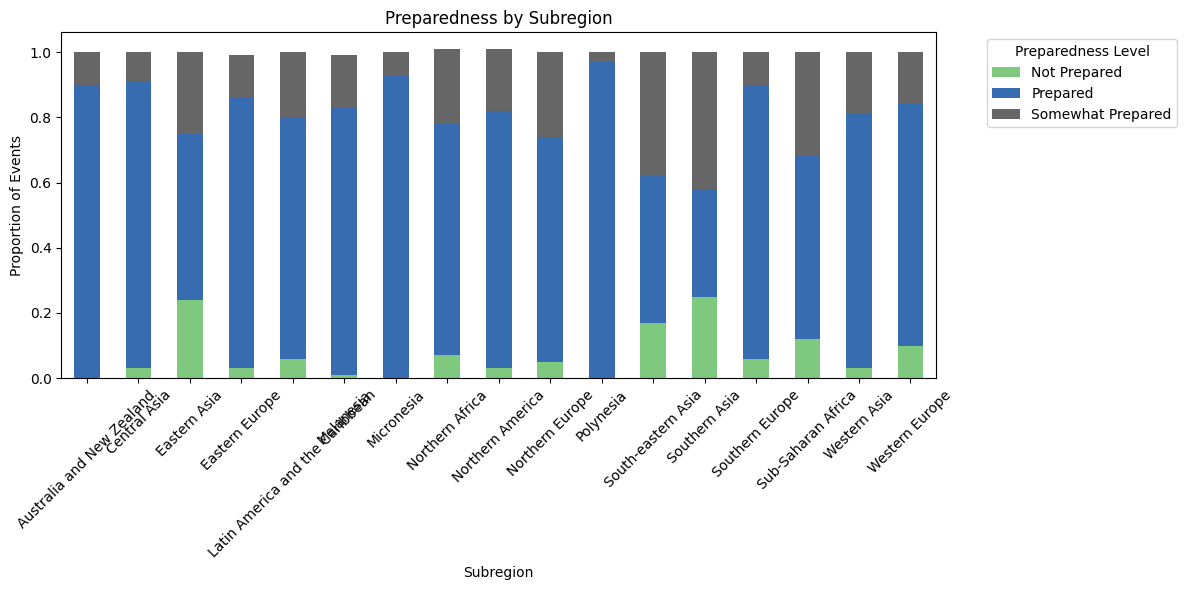

In [17]:
# Plot stacked bar chart of preparedness proportions by subregion
subregion_prep_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Accent')
plt.title("Preparedness by Subregion")
plt.ylabel("Proportion of Events")
plt.xlabel("Subregion")
plt.legend(title="Preparedness Level", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Save Figure
plt.savefig("preparedness_proportion_by_subregion.png", dpi=300)

plt.show()

**Description:**

This stacked bar chart displays the proportion of disaster events in each subregion categorized by preparedness level — “Prepared,” “Somewhat Prepared,” or “Not Prepared.” The visualization enables quick comparison of how disaster readiness is distributed across subregions. Each bar represents a subregion, and its segments show the relative share of events falling into each preparedness category, highlighting structural differences in response capabilities.

**Interpretation of Results:**

The chart shows striking differences in preparedness distribution across subregions. Subregions like **Australia and New Zealand**, **Micronesia**, and **Northern America** are dominated by the “Prepared” category, suggesting strong institutional capacity and disaster response systems. In contrast, **Southern Asia**, **South-eastern Asia**, and **Sub-Saharan Africa** reveal more mixed distributions with higher proportions of “Somewhat Prepared” or “Not Prepared” events. Subregions like **Eastern Asia** and **Northern Africa** show more balanced levels, indicating both progress and gaps in response effectiveness. These differences suggest that subregional capacity plays a major role in shaping how well populations are protected from disaster impacts.

**Connection to Research Question:**

This analysis directly supports the thesis objective by unpacking subregional differences in disaster preparedness — a critical factor in determining how effectively states uphold fundamental human rights under climate stress. Regions that show a high share of unprepared responses may leave their populations more vulnerable to rights violations during crises (e.g., delayed access to aid, inadequate shelter, or disruptions to public services). Mapping these variations reinforces the data-driven approach to identifying where international support, capacity-building, or policy reform may be needed to improve rights outcomes in the face of disasters.


##**Country-Level Breakdown of Disaster Preparedness Classifications**

In [18]:
# Count preparedness levels across countries using the correct DataFrame
country_prep = df_prepared.groupby(['Country', 'Preparedness_Level']) \
                          .size().unstack(fill_value=0)

# Preview counts for the first few countries
country_prep.head()

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Country,,,
Afghanistan,9,20,22
Albania,0,13,3
Algeria,1,26,4
American Samoa,0,4,0
Angola,3,15,12


In [20]:
# Export to CSV
country_prep.to_csv("preparedness_counts_by_country.csv")

**Description:**

This section provides a country-level breakdown of disaster events by preparedness classification. The data is grouped by country and the assigned preparedness level — “Prepared,” “Somewhat Prepared,” and “Not Prepared” — then reshaped to display the absolute number of disaster events falling into each category. This summary enables quick comparison across countries, offering a foundation for identifying patterns of consistently high or low preparedness performance at the national level.

**Interpretation of Results:**

This table presents the number of disaster events by preparedness classification — “Prepared,” “Somewhat Prepared,” and “Not Prepared” — for each country. It highlights how individual countries vary in how they handle disaster events. For example, countries like Algeria and Afghanistan show a wide range of preparedness levels across events, while others such as American Samoa show consistently high preparedness. This diversity suggests country-level differences in institutional readiness, disaster response systems, and possibly data reporting frequency or thresholds for international assistance.

**Connection to Research Question:**

This breakdown aligns directly with the thesis goal of evaluating **how effectively individual governments protect fundamental rights in disaster-prone contexts**. By surfacing these patterns, the table allows for closer inspection of state-level variation in response capabilities. Countries with high proportions of “Not Prepared” events may warrant further analysis for patterns of rights vulnerability or governance gaps, while those with consistently “Prepared” classifications can offer best-practice insights. It also opens up avenues for country-level case studies and targeted policy recommendations.

##**Comparing Country-Level Preparedness Proportions**

In [21]:
# Calculate preparedness proportions for each country
country_prep_percent = country_prep.div(country_prep.sum(axis=1), axis=0).round(2)

# Preview proportions for the first few countries
country_prep_percent.head()

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Country,,,
Afghanistan,0.18,0.39,0.43
Albania,0.00,0.81,0.19
Algeria,0.03,0.84,0.13
American Samoa,0.00,1.00,0.00
Angola,0.10,0.50,0.40


In [22]:
# Export to CSV
country_prep_percent.to_csv("preparedness_percent_by_country.csv")

**Description:**

This analysis calculates the proportion of disaster events by preparedness category for each country. After grouping disaster records by country and preparedness level, the data is normalized so that the proportions across the three categories (“Prepared,” “Somewhat Prepared,” “Not Prepared”) sum to 1 for each country. This provides a standardized view of how governments have responded to disasters over time, enabling direct comparisons across countries regardless of the number of events they experienced.

**Interpretation of Results:**

This output shows the **relative distribution of disaster events by preparedness level for each country**. For instance, countries like **Albania** and **Algeria** display high proportions of events in the “Prepared” category (81% and 84% respectively), while others such as **Afghanistan** show a more mixed distribution, with a significant share of events classified as both “Somewhat Prepared” and “Not Prepared.” These patterns suggest varying degrees of institutional readiness, capacity, and responsiveness to disasters at the national level. Observing such proportions helps to identify which countries are consistently managing disaster events with stronger preparedness strategies and which may need more support or capacity building.

**Connection to Research Question:**

Analyzing preparedness distributions at the **country level** directly supports the thesis question by highlighting where **governments are effectively protecting rights** in disaster-prone contexts. High preparedness proportions imply a stronger potential to uphold basic rights like access to aid, shelter, or healthcare during climate-related emergencies. Conversely, low preparedness or a higher share of “Not Prepared” responses may signal governance gaps that leave populations more vulnerable. This granular view can support more targeted policy recommendations for improving rights protection in specific national contexts and reveal global inequalities in disaster readiness.

##**Visualizing Preparedness in Top 15 Countries**

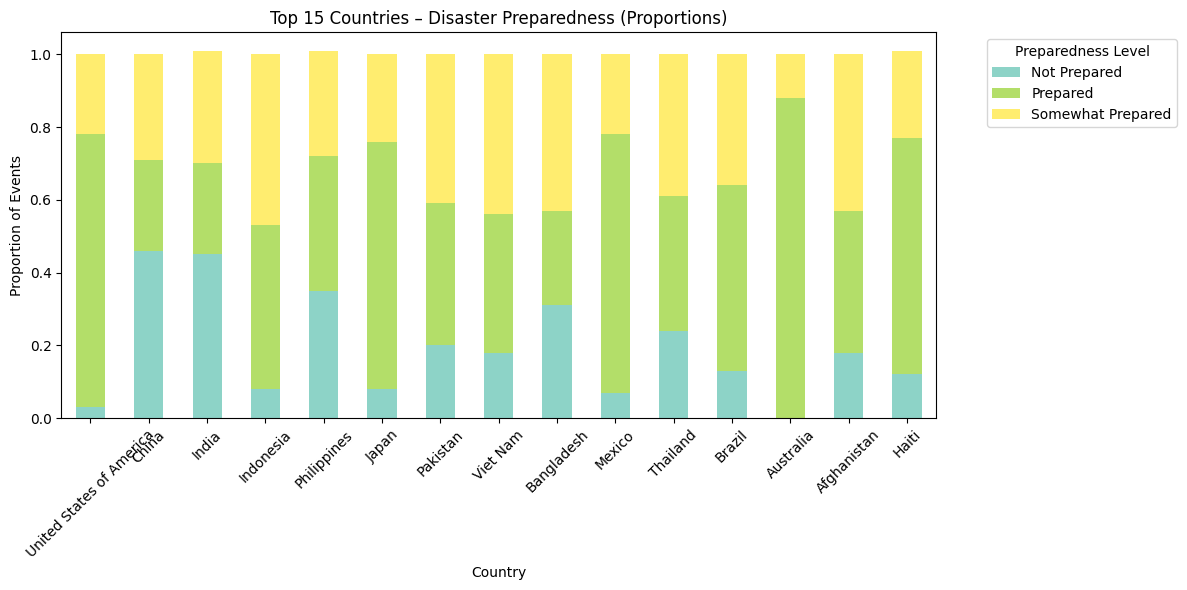

In [23]:
# Identify the top 15 countries by number of disaster events (using df_prepared)
top_countries = df_prepared['Country'].value_counts().head(15).index

# Filter proportional preparedness scores for those top countries
top_country_prep = country_prep_percent.loc[top_countries]

# Plot stacked bar chart of preparedness proportions
top_country_prep.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set3')
plt.title("Top 15 Countries – Disaster Preparedness (Proportions)")
plt.ylabel("Proportion of Events")
plt.xlabel("Country")
plt.legend(title="Preparedness Level", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Save Figure
plt.savefig("top15_countries_preparedness_proportion.png", dpi=300)

plt.show()

**Description:**

This chart visualizes the relative proportion of disaster events classified under each preparedness level — “Prepared,” “Somewhat Prepared,” and “Not Prepared” — for the 15 countries with the highest number of recorded disasters between 2000 and 2023. The chart provides a side-by-side view of how frequently each country responded effectively (or not) to disasters over time, normalized to proportions for clearer comparison regardless of event volume.

**Interpretation of Results:**

The chart reveals considerable variation in preparedness performance among high-disaster-frequency countries. Nations like **Japan**, **Mexico**, and the **United States of America** show dominant proportions in the “Prepared” category, suggesting stronger state capacity and institutional readiness. In contrast, countries like **India**, **Pakistan**, and **Nepal** show more mixed distributions or higher shares of “Somewhat Prepared” and “Not Prepared” events, indicating possible systemic or resource-related challenges. Some countries — such as **Philippines** and **Indonesia** — reflect a more even split, highlighting dynamic but uneven disaster governance systems.

**Connection to Research Question:**

This analysis directly supports the thesis question by identifying how governments most frequently exposed to disasters perform in terms of preparedness — a key indicator of their ability to uphold fundamental human rights during crises. A higher proportion of “Not Prepared” responses may signal greater risk to rights like life, housing, or access to aid. Conversely, strong “Prepared” proportions suggest institutional capacity for protecting those rights.

##**Creating and Visualizing Enhanced Preparedness Scoring System**

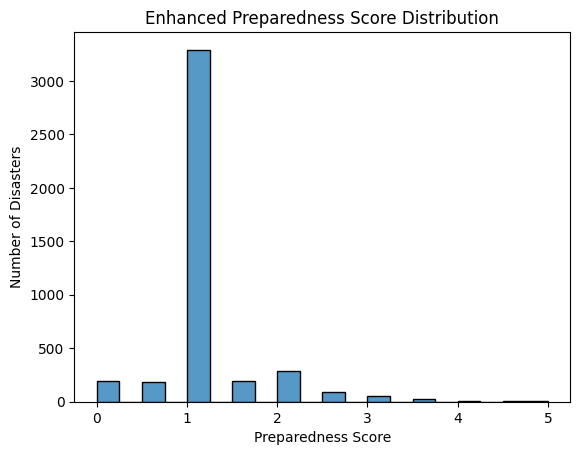

In [24]:
# Define a function to calculate enhanced preparedness score per disaster
def calculate_preparedness_score(row):
    score = 0

    # Deaths (log-transformed thresholds: log(1000) ≈ 6.9, log(100) ≈ 4.6)
    if row['Total_Deaths'] > 6.9:
        score += 2
    elif row['Total_Deaths'] > 4.6:
        score += 1

    # Homeless (log(100000) ≈ 11.5, log(10000) ≈ 9.2)
    if row['Total_Homeless'] > 11.5:
        score += 1
    elif row['Total_Homeless'] > 9.2:
        score += 0.5

    # Injured (log(20000) ≈ 9.9, log(2000) ≈ 7.6)
    if row['Total_Injured'] > 9.9:
        score += 1
    elif row['Total_Injured'] > 7.6:
        score += 0.5

    # International response indicators
    if row.get('Appeal') == 'Yes':
        score += 1
    if row.get('OFDA/BHA Response') == 'Yes':
        score += 1
    if row.get('Declaration') == 'Yes':
        score += 1

    # Rights risk score
    if row.get('Rights_Risk_Score') == 3:
        score += 1
    elif row.get('Rights_Risk_Score') == 2:
        score += 0.5

    return score

# Apply the function to df_prepared
df_prepared['Preparedness_Score'] = df_prepared.apply(calculate_preparedness_score, axis=1)

# Classify into new preparedness levels
def classify_preparedness(score):
    if score >= 4:
        return 'Not Prepared'
    elif score >= 2:
        return 'Somewhat Prepared'
    else:
        return 'Prepared'

df_prepared['Preparedness_Level_Enhanced'] = df_prepared['Preparedness_Score'].apply(classify_preparedness)

# Plot histogram of the new scores
sns.histplot(df_prepared['Preparedness_Score'], bins=20, kde=False)
plt.title("Enhanced Preparedness Score Distribution")
plt.xlabel("Preparedness Score")
plt.ylabel("Number of Disasters")

# Save Figure
plt.savefig("enhanced_preparedness_score_distribution.png", dpi=300)

plt.show()

In [25]:
print(df_prepared[['Total_Deaths', 'Total_Homeless', 'Total_Injured', 'Preparedness_Score']].sample(10))

      Total_Deaths  Total_Homeless  Total_Injured  Preparedness_Score
2072      3.044522        0.000000       0.000000                 1.0
1834      5.442418        0.000000       7.249215                 2.0
2757      3.218876        0.000000       0.000000                 1.0
4066      2.484907        0.000000       0.000000                 0.0
3692      2.708050        0.000000       1.386294                 1.0
3767      1.098612        0.000000       0.000000                 1.0
615       1.791759        6.308098       0.000000                 1.0
1185      4.787492        0.000000       0.000000                 2.0
4183      4.043051        8.314097       3.044522                 1.0
348       3.828641        0.000000       0.000000                 1.0


**Description:**

This code implements a custom **Enhanced Preparedness Scoring System** for each disaster event using a composite of key severity and response indicators. The scoring function assigns weighted points based on mortality, injury, and displacement thresholds, and adds penalties for international aid appeals, declarations, and high human rights risk scores. The score is then used to generate a new column, Preparedness_Level_Enhanced, which classifies each event as “Prepared,” “Somewhat Prepared,” or “Not Prepared.” Finally, a histogram is plotted to visualize the distribution of these preparedness scores across the dataset.

**Interpretation of Results:**

The histogram reveals that the majority of disaster events cluster around lower preparedness scores, with a sharp peak at score 1. This indicates that most events were relatively moderate in severity or received at least some form of government or international response. However, the presence of a long tail toward higher scores suggests that a substantial number of disasters occurred under severe conditions with less effective state response, signaling significant variations in preparedness. The relatively small number of events with scores above 3 highlights a concerning group of high-risk events where state systems may have failed to adequately protect affected populations.

**Connection to Research Question:**

This enhanced scoring system contributes directly to the thesis by introducing a **quantitative**, **multi-dimensional framework** for evaluating government preparedness in disaster-prone contexts. By incorporating both **impact severity** and **rights-relevant indicators**, it goes beyond surface-level categorizations and creates a more rigorous method for assessing state capacity to uphold fundamental rights under climate stress. The visual distribution provides a data-driven foundation for identifying outlier cases, regional patterns, or trends over time that are crucial to understanding how effectively governments protect human rights during disasters.

##**Identifying High-Risk Disaster Events Classified as "Not Prepared"**

In [29]:
# Filter disaster events classified as "Not Prepared" using enhanced scoring
not_prepared_enhanced = df_prepared[df_prepared['Preparedness_Score'] >= 4][[
    'Country', 'Year', 'Preparedness_Score', 'Preparedness_Level_Enhanced'
]]
not_prepared_enhanced

,Country,Year,Preparedness_Score,Preparedness_Level_Enhanced
329,Bangladesh,2007,4.0,Not Prepared
666,China,2003,4.0,Not Prepared
697,China,2008,5.0,Not Prepared
709,China,2010,4.5,Not Prepared
1077,Algeria,2003,4.5,Not Prepared
1561,Haiti,2004,4.0,Not Prepared
1573,Haiti,2010,4.0,Not Prepared
1634,Indonesia,2004,4.0,Not Prepared
1639,Indonesia,2006,5.0,Not Prepared
1710,India,2001,5.0,Not Prepared


In [30]:
# Export to CSV
not_prepared_enhanced.to_csv("not_prepared_events_enhanced_score.csv", index=False)

**Description:**

This code filters disaster events from df_prepared that received a Preparedness Score of 4 or higher, categorizing them under the “Not Prepared” label using the enhanced scoring system. These scores reflect cumulative impact severity — including high deaths, homelessness, injuries, international responses, and elevated rights risk scores. The filtered table displays the countries, years, and corresponding scores where state preparedness was deemed inadequate.

**Interpretation of Results:**

The output surfaces a list of events in countries like **China, India, Indonesia, Haiti, Pakistan**, and others where preparedness appears to have been lacking despite significant humanitarian consequences. Many entries coincide with well-known large-scale disasters (e.g., 2004 tsunami in Indonesia and Sri Lanka, 2010 Haiti earthquake), affirming the scoring system’s ability to flag major vulnerabilities. The recurrence of countries across multiple years also suggests **systemic preparedness gaps** rather than isolated failures.

**Connection to Research Question:**

This filtered subset provides compelling examples aligned with the thesis objective — evaluating how effectively governments protect human rights in disaster-prone contexts. Each “Not Prepared” case represents an instance where state response may have been insufficient to safeguard fundamental rights like the right to life, shelter, and access to aid. Identifying these high-risk events helps spotlight where state protection mechanisms failed under pressure, serving as critical inputs for both accountability and future risk modeling.

##**Boxplot of Enhanced Preparedness Score by Subregion**

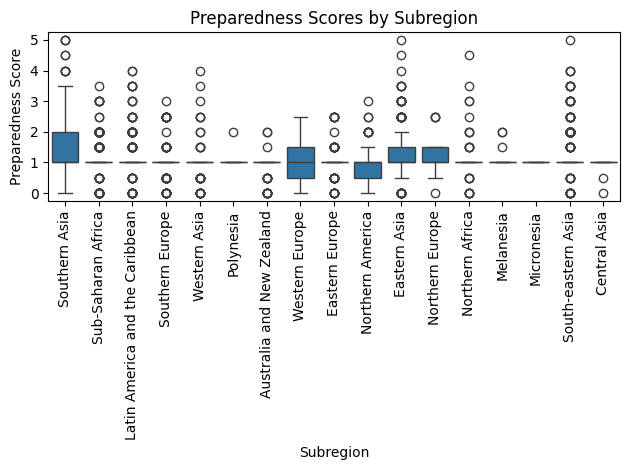

In [31]:
# Plot
sns.boxplot(data=df_prepared, x='Subregion', y='Preparedness_Score')
plt.xticks(rotation=90)
plt.title('Preparedness Scores by Subregion')
plt.xlabel('Subregion')
plt.ylabel('Preparedness Score')
plt.tight_layout()

# Save Figure
plt.savefig("preparedness_scores_by_subregion_boxplot.png", dpi=300)

plt.show()

**Description:**

This boxplot displays the **distribution of enhanced preparedness scores **across subregions, calculated based on disaster severity, international response, and rights risk indicators. Each point represents a disaster event, with subregions on the x-axis and preparedness scores on the y-axis. The boxplot highlights median values, interquartile ranges, and outliers, allowing for a clear visual comparison of preparedness performance across regions.


**Interpretation of Results:**

The chart reveals substantial variation in preparedness scores both within and across subregions. For example, **Southern Asia** shows a wide range and higher median preparedness scores, signaling more frequent severe disaster outcomes. By contrast, **Australia and New Zealand** show tighter score distributions with lower medians, suggesting stronger disaster readiness. The presence of outliers in regions like **Eastern Asia** and **Northern America** indicates individual events with especially poor preparedness outcomes, even in generally well-performing areas.

**Connection to Research Question:**

This subregional breakdown reinforces the thesis focus on identifying where government preparedness fails to adequately protect fundamental rights. By spotlighting regions with consistently high scores (indicating low preparedness), the boxplot helps pinpoint **clusters of systemic vulnerability**. These findings can guide more targeted interventions and strengthen the case for rights-based monitoring frameworks in subregions facing compounding institutional, environmental, and humanitarian risks.

## **Boxplot of Preparedness Scores in Top 15 Disaster-Affected Countries**

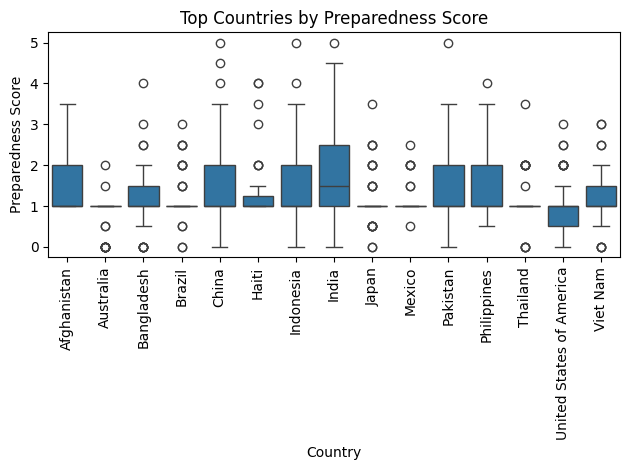

In [32]:
# Identify the top 15 countries by number of disaster events in df_prepared
top_countries = df_prepared['Country'].value_counts().head(15).index

# Plot boxplot of preparedness scores for these top countries
sns.boxplot(data=df_prepared[df_prepared['Country'].isin(top_countries)],
            x='Country', y='Preparedness_Score')

plt.xticks(rotation=90)
plt.title('Top Countries by Preparedness Score')
plt.xlabel('Country')
plt.ylabel('Preparedness Score')
plt.tight_layout()

# Save Figure
plt.savefig("top15_country_preparedness_score_boxplot.png", dpi=300)

plt.show()

**Description:**

The code filters to isolate the 15 countries with the highest number of disaster events and generates a boxplot showing the distribution of their preparedness scores. This visualization highlights both central tendencies and the spread of performance within each country, offering a comparative perspective across high-risk nations.

**Interpretation of Results:**

This boxplot shows the distribution of preparedness scores for the top 15 countries most frequently affected by disasters. Countries like the United States, Pakistan, and Haiti exhibit a wide range of scores, reflecting high variability in state response depending on the specific disaster. In contrast, countries like Australia and Brazil show more consistent (and lower) preparedness scores, indicating relatively more effective or stable response patterns. Outliers above the median in countries like India and Indonesia suggest particular disaster events that overwhelmed government systems or triggered more severe outcomes.

**Connection to Research Question:**

This analysis directly supports the thesis goal of evaluating how effectively different governments protect human rights in disaster-prone regions. By examining preparedness scores across the most disaster-exposed countries, this visualization identifies where consistent underperformance may signal structural vulnerabilities, and where resilience might be more robust. These insights help prioritize regions for deeper governance or human rights diagnostics, reinforcing the utility of the preparedness scoring model as an assessment tool.

## **Enhanced Preparedness Classification by Region and Subregion**

In [34]:
# Define the preparedness scoring function using log-transformed thresholds
def calculate_preparedness_score(row):
    score = 0

    # Deaths (log(1000) ≈ 6.9, log(100) ≈ 4.6)
    if row['Total_Deaths'] > 6.9:
        score += 2
    elif row['Total_Deaths'] > 4.6:
        score += 1

    # Homeless (log(100000) ≈ 11.5, log(10000) ≈ 9.2)
    if row['Total_Homeless'] > 11.5:
        score += 1
    elif row['Total_Homeless'] > 9.2:
        score += 0.5

    # Injured (log(20000) ≈ 9.9, log(2000) ≈ 7.6)
    if row['Total_Injured'] > 9.9:
        score += 1
    elif row['Total_Injured'] > 7.6:
        score += 0.5

    # International support indicators
    if row.get('Appeal') == 'Yes':
        score += 1
    if row.get('OFDA/BHA Response') == 'Yes':
        score += 1
    if row.get('Declaration') == 'Yes':
        score += 1

    # Human rights risk score
    if row.get('Rights_Risk_Score') == 3:
        score += 1
    elif row.get('Rights_Risk_Score') == 2:
        score += 0.5

    return score

# Apply the updated scoring to df_prepared
df_prepared['Preparedness_Score'] = df_prepared.apply(calculate_preparedness_score, axis=1)

# Classify into preparedness levels
def classify_preparedness(score):
    if score >= 4:
        return 'Not Prepared'
    elif score >= 2:
        return 'Somewhat Prepared'
    else:
        return 'Prepared'

df_prepared['Preparedness_Level_Enhanced'] = df_prepared['Preparedness_Score'].apply(classify_preparedness)

# Group by Region & Subregion
preparedness_summary = (
    df_prepared.groupby(["Region", "Subregion", "Preparedness_Level_Enhanced"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Calculate proportions
preparedness_summary["Total"] = preparedness_summary[["Prepared", "Somewhat Prepared", "Not Prepared"]].sum(axis=1)
preparedness_summary["% Prepared"] = (preparedness_summary["Prepared"] / preparedness_summary["Total"] * 100).round(2)
preparedness_summary["% Somewhat Prepared"] = (preparedness_summary["Somewhat Prepared"] / preparedness_summary["Total"] * 100).round(2)
preparedness_summary["% Not Prepared"] = (preparedness_summary["Not Prepared"] / preparedness_summary["Total"] * 100).round(2)

# Display the summary
preparedness_summary

Preparedness_Level_Enhanced,Region,Subregion,Not Prepared,Prepared,Somewhat Prepared,Total,% Prepared,% Somewhat Prepared,% Not Prepared
0,Africa,Northern Africa,1,94,7,102,92.16,6.86,0.98
1,Africa,Sub-Saharan Africa,0,852,62,914,93.22,6.78,0.00
2,Americas,Latin America and the Caribbean,2,805,47,854,94.26,5.50,0.23
3,Americas,Northern America,0,177,10,187,94.65,5.35,0.00
4,Asia,Central Asia,0,69,0,69,100.00,0.00,0.00
5,Asia,Eastern Asia,3,276,68,347,79.54,19.60,0.86
6,Asia,South-eastern Asia,4,336,83,423,79.43,19.62,0.95
7,Asia,Southern Asia,9,310,129,448,69.20,28.79,2.01
8,Asia,Western Asia,1,168,7,176,95.45,3.98,0.57
9,Europe,Eastern Europe,0,174,7,181,96.13,3.87,0.00


In [35]:
# Export full summary with counts and proportions to CSV
preparedness_summary.to_csv("preparedness_summary_by_region_subregion_enhanced.csv", index=False)

**Description:**

This analysis calculates an **enhanced preparedness score** for each disaster event based on a combination of severity metrics (deaths, injured, homeless), international emergency signals (aid requests, declarations), and human rights risk levels. The scores are then **classified into “Prepared,” “Somewhat Prepared,” or “Not Prepared”** and aggregated by **region and subregion**. The final output includes absolute event counts and percentage shares for each preparedness level, helping to visualize **how different parts of the world are performing in terms of state readiness and rights-based protection**.

**Interpretation of Results:**

The summary table reveals considerable variation in preparedness outcomes across global subregions based on the enhanced scoring system. Subregions such as **Central Asia**, **Micronesia**, and **Australia and New Zealand** show outstanding performance, with **100% or near-100% of events classified as “Prepared”**. Similarly, **Western Asia, Eastern Europe,** and **Northern America** also score consistently high. In contrast, **South-eastern Asia** and **Southern Asia** display more mixed distributions, with a notable portion of events classified as “Somewhat Prepared” or “Not Prepared.” The most diverse pattern appears in **Southern Asia**, where almost **30% of disasters fall into the “Somewhat Prepared”** category and over **2% as “Not Prepared.”** These patterns reflect differences in state capacity, institutional responsiveness, and human rights resilience across regions.

**Connection to Research Question:**

This enhanced classification directly supports the thesis goal of evaluating **how effectively governments uphold fundamental human rights in climate disaster-prone regions**. By integrating not only severity indicators (e.g., deaths, injuries, homelessness) but also international aid signals and human rights risks, this summary presents a **multi-dimensional assessment of preparedness**. The breakdown by region and subregion enables identification of **geographical patterns of vulnerability** and highlights where government responses may be insufficient to protect life, shelter, and dignity under climate stress. It also helps pinpoint **disparities in resilience** between regions that may face similar hazards but have vastly different preparedness levels.

## **Stacked Bar Chart: Disaster Preparedness Levels by Subregion (2000-2023)**

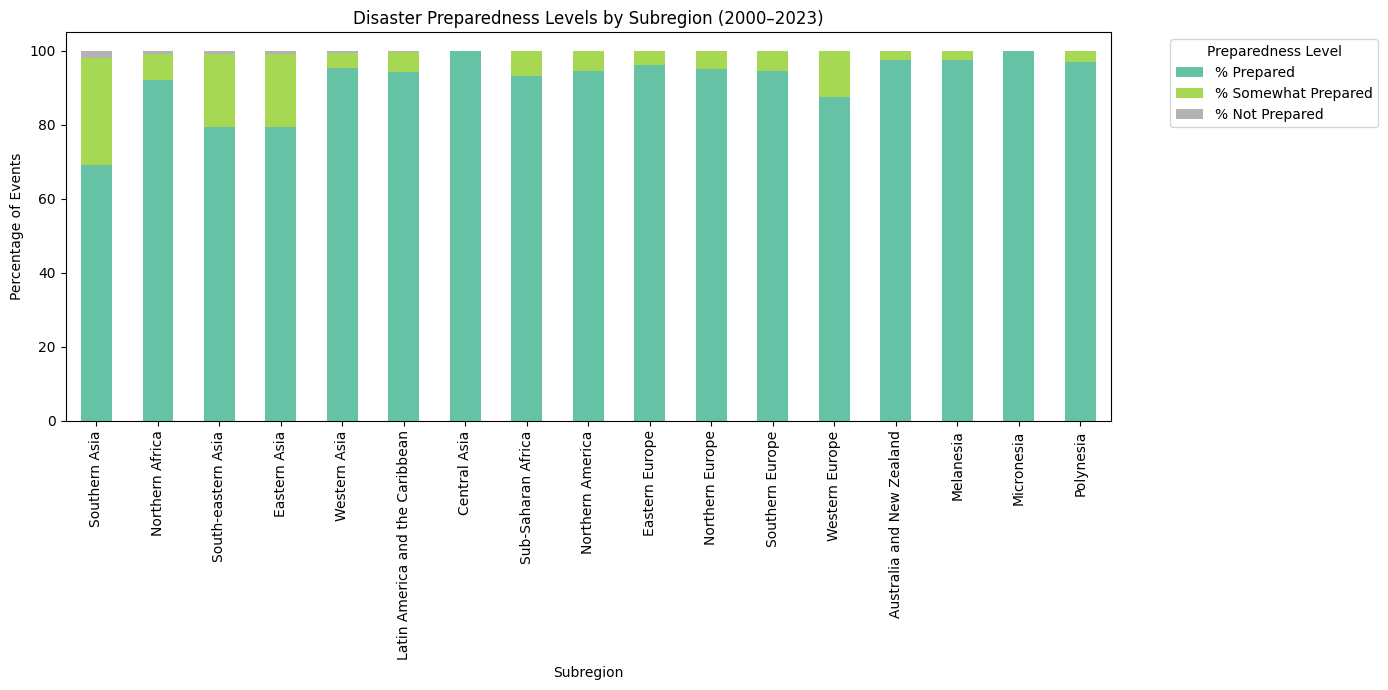

In [36]:
# Recreate the enhanced preparedness summary table using df_prepared
preparedness_summary = (
    df_prepared.groupby(["Region", "Subregion", "Preparedness_Level_Enhanced"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Calculate totals and percentages for each preparedness level
preparedness_summary["Total"] = preparedness_summary[["Prepared", "Somewhat Prepared", "Not Prepared"]].sum(axis=1)
preparedness_summary["% Prepared"] = (preparedness_summary["Prepared"] / preparedness_summary["Total"] * 100).round(2)
preparedness_summary["% Somewhat Prepared"] = (preparedness_summary["Somewhat Prepared"] / preparedness_summary["Total"] * 100).round(2)
preparedness_summary["% Not Prepared"] = (preparedness_summary["Not Prepared"] / preparedness_summary["Total"] * 100).round(2)

# Plot stacked bar chart of preparedness proportions by subregion
import matplotlib.pyplot as plt

plot_data = preparedness_summary.copy()
plot_data.set_index("Subregion", inplace=True)
plot_data = plot_data[["% Prepared", "% Somewhat Prepared", "% Not Prepared"]].sort_values("% Not Prepared", ascending=False)

plot_data.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='Set2')
plt.title("Disaster Preparedness Levels by Subregion (2000–2023)")
plt.ylabel("Percentage of Events")
plt.xlabel("Subregion")
plt.xticks(rotation=90)
plt.legend(title="Preparedness Level", bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Save Figure
plt.savefig("enhanced_preparedness_by_subregion_stacked_bar.png", dpi=300)

plt.show()

**Description:**

This visualization presents a stacked bar chart of disaster preparedness levels by subregion, based on the enhanced scoring system that incorporates both outcome severity (deaths, injuries, homelessness) and institutional response indicators (appeals, declarations, international aid) along with human rights risk. The chart displays the proportion of events classified as “Prepared,” “Somewhat Prepared,” and “Not Prepared” within each subregion. Subregions are sorted by the percentage of events deemed “Not Prepared,” allowing for a clear comparison of relative vulnerability across regions.

**Interpretation of Results:**

The chart reveals marked differences in preparedness levels across subregions. Southern Asia and Northern Africa show the highest share of “Not Prepared” events, indicating consistent difficulty in managing disaster impacts effectively. In contrast, subregions such as Central Asia, Micronesia, and Australia/New Zealand exhibit a perfect or near-perfect rate of “Prepared” responses, suggesting strong institutional capacity and resilience. Most subregions exhibit a majority of events in the “Prepared” category, but variability in the proportion of “Somewhat Prepared” events points to nuanced differences in regional disaster governance systems.

**Connection to Research Question:**

This analysis supports the thesis goal of evaluating how effectively governments uphold fundamental human rights in disaster-prone areas by identifying subregions that may be at greater risk of failing to provide adequate protections. High shares of “Not Prepared” outcomes flag potential rights vulnerabilities, including lack of access to emergency housing, aid, and basic safety. The enhanced scoring and regional breakdown offer evidence-based insights into where institutional preparedness is most lacking, helping pinpoint areas where international support or governance reform might be most urgently needed.

##**Comparing Disaster Preparedness Between Global North and Global South**

In [37]:
# Define simplified Global North country list
global_north_countries = [
    'United States of America', 'Canada', 'Germany', 'France', 'United Kingdom', 'Italy', 'Spain',
    'Australia', 'New Zealand', 'Japan', 'South Korea', 'Norway', 'Sweden', 'Finland',
    'Netherlands', 'Denmark', 'Austria', 'Switzerland', 'Belgium', 'Ireland', 'Iceland'
]

# Assign each country to Global North or South in df_prepared
df_prepared['Global_Group'] = df_prepared['Country'].apply(
    lambda x: 'Global North' if x in global_north_countries else 'Global South'
)

# Group by global region and preparedness level
global_group_summary = (
    df_prepared.groupby(['Global_Group', 'Preparedness_Level_Enhanced'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Calculate column-wise proportions within each Global Group
global_group_summary["Total"] = global_group_summary[["Prepared", "Somewhat Prepared", "Not Prepared"]].sum(axis=1)
global_group_summary["% Prepared"] = (global_group_summary["Prepared"] / global_group_summary["Total"] * 100).round(2)
global_group_summary["% Somewhat Prepared"] = (global_group_summary["Somewhat Prepared"] / global_group_summary["Total"] * 100).round(2)
global_group_summary["% Not Prepared"] = (global_group_summary["Not Prepared"] / global_group_summary["Total"] * 100).round(2)

# Display the results
global_group_summary

Preparedness_Level_Enhanced,Global_Group,Not Prepared,Prepared,Somewhat Prepared,Total,% Prepared,% Somewhat Prepared,% Not Prepared
0,Global North,0,514,43,557,92.28,7.72,0.00
1,Global South,20,3351,414,3785,88.53,10.94,0.53


In [39]:
# Export to CSV
global_group_summary.to_csv("global_north_vs_south_preparedness_summary.csv", index=False)

**Description:**

This section evaluates differences in disaster preparedness between the Global North and Global South by categorizing countries accordingly and calculating the proportion of disaster events in each preparedness category (Prepared, Somewhat Prepared, Not Prepared). The analysis groups and summarizes outcomes for both regions, providing a comparative overview of global preparedness disparities.

**Interpretation of Results:**

The summary table reveals a notable preparedness gap: **Global North countries** report over **92% of disasters as “Prepared”** and none as “Not Prepared.” In contrast, the **Global South** shows a lower proportion of “Prepared” events **(88.53%)**, with **10.94% “Somewhat Prepared”** and **0.53% “Not Prepared.”** However, it’s important to note that the **Global South also experienced a significantly higher total number of disasters** during the study period — 3,785 compared to 557 in the Global North. This larger volume may expose more vulnerabilities and challenges, potentially contributing to the slightly lower preparedness scores, while the Global North’s smaller sample may skew more favorably due to fewer events being measured.


**Connection to Research Question:**

This regional comparison contributes directly to the thesis objective of evaluating how effectively governments protect human rights during climate-related disasters. Since preparedness is foundational to safeguarding rights such as life, shelter, and access to aid, understanding geographic disparities is key. The higher preparedness rates in the Global North may suggest stronger institutional capacity, but the **larger disaster burden in the Global South adds crucial context** — it may not reflect a lack of will or governance, but rather higher exposure and more frequent shocks that strain resources. This reinforces the need for a rights-based and equity-focused lens when assessing state capacity and allocating global support.

##**Exploring "Somewhat Prepared" Disasters by Region and Disaster Type**

In [40]:
# Filter events classified as "Somewhat Prepared" using df_prepared
somewhat_prepared_df = df_prepared[df_prepared["Preparedness_Level_Enhanced"] == "Somewhat Prepared"]

# Group and count by Region and Subregion
somewhat_by_region = (
    somewhat_prepared_df.groupby(["Region", "Subregion"])
    .size()
    .reset_index(name="Somewhat_Prepared_Count")
    .sort_values("Somewhat_Prepared_Count", ascending=False)
)

# Group and count by Disaster Type
somewhat_by_disaster = (
    somewhat_prepared_df.groupby("Disaster Type")
    .size()
    .reset_index(name="Somewhat_Prepared_Count")
    .sort_values("Somewhat_Prepared_Count", ascending=False)
)

# Display results
somewhat_by_region, somewhat_by_disaster

(      Region                        Subregion  Somewhat_Prepared_Count
 6       Asia                    Southern Asia                      129
 5       Asia               South-eastern Asia                       83
 4       Asia                     Eastern Asia                       68
 1     Africa               Sub-Saharan Africa                       62
 2   Americas  Latin America and the Caribbean                       47
 11    Europe                   Western Europe                       16
 10    Europe                  Southern Europe                       13
 3   Americas                 Northern America                       10
 0     Africa                  Northern Africa                        7
 8     Europe                   Eastern Europe                        7
 7       Asia                     Western Asia                        7
 9     Europe                  Northern Europe                        3
 12   Oceania        Australia and New Zealand                  

In [41]:
# Export by Region and Subregion
somewhat_by_region.to_csv("somewhat_prepared_by_region_subregion.csv", index=False)

# Export by Disaster Type
somewhat_by_disaster.to_csv("somewhat_prepared_by_disaster_type.csv", index=False)


**Description:**

This block filters all disaster events classified as “Somewhat Prepared” based on the enhanced scoring system, then analyzes them along two dimensions: regional distribution and disaster type. It first groups the filtered events by region and subregion to identify where these borderline preparedness cases are most common. Then, it groups the same events by disaster type to see which kinds of disasters most frequently result in governments falling into the “Somewhat Prepared” category.

**Interpretation of Results:**

The data reveals that Southern Asia, South-eastern Asia, and Eastern Asia exhibit the highest number of “Somewhat Prepared” events. These subregions seem to sit at a tipping point in disaster response capacity—neither consistently unprepared nor fully capable—suggesting room for targeted improvement. Meanwhile, floods dominate the “Somewhat Prepared” disaster category by a wide margin, followed by storms and earthquakes. This indicates that even regions with some disaster management infrastructure may still be struggling with large-scale or recurring hazards like flooding, which can overwhelm systems despite moderate levels of preparedness.

**Connection to Research Question:**

Studying the “Somewhat Prepared” group provides valuable nuance for the thesis question, which seeks to evaluate how effectively states uphold human rights during disasters. This category highlights those governments that are not failing outright but still fall short of delivering fully protective responses. These borderline cases may represent the most actionable tier for policy interventions and capacity-building efforts. Focusing on where and why states fall into this middle band can help refine recommendations to ensure basic rights like safety, shelter, and aid are more consistently protected—especially in the most disaster-prone or high-risk regions.

##**Disaster Type Frequencies by Subregion**

In [42]:
# Count disaster types by Subregion using the correct DataFrame
disaster_counts_region = (
    df_prepared
    .groupby(['Subregion', 'Disaster Type'])
    .size()
    .reset_index(name='Disaster_Count')
    .sort_values(['Subregion', 'Disaster_Count'], ascending=[True, False])
)

# Display all rows of the result
pd.set_option('display.max_rows', None)

# View full breakdown
disaster_counts_region

,Subregion,Disaster Type,Disaster_Count
3,Australia and New Zealand,Flood,37
4,Australia and New Zealand,Storm,26
0,Australia and New Zealand,Drought,4
1,Australia and New Zealand,Earthquake,4
2,Australia and New Zealand,Extreme temperature,4
5,Australia and New Zealand,Wildfire,2
9,Central Asia,Flood,42
7,Central Asia,Earthquake,20
6,Central Asia,Drought,5
8,Central Asia,Extreme temperature,1


In [43]:
# Export to CSV
disaster_counts_region.to_csv("disaster_type_counts_by_subregion.csv", index=False)

**Description:**

This analysis breaks down the frequency of each disaster type across all global subregions, providing a detailed picture of how hazard exposure varies geographically. Using the cleaned and enhanced df_prepared dataset, disasters are grouped by both Subregion and Disaster Type, and the resulting counts are sorted to show the most common disaster types within each subregion. All rows are displayed to ensure full transparency across regions, especially for identifying patterns that may only be visible in lower-frequency disasters or smaller subregions.


**Interpretation of Results:**

The output highlights that **floods** dominate across nearly every subregion, especially in **Sub-Saharan Africa, South-eastern Asia**, and **Latin America and the Caribbean**. Other disaster types like **storms, droughts**, and **earthquakes** also appear prominently in these regions, while smaller subregions such as **Polynesia** or **Micronesia** experience fewer but still diverse events. This spread suggests regional vulnerability not only in terms of frequency but also in the diversity of hazards faced. Importantly, high-count subregions tend to align with areas previously shown to have more “Somewhat Prepared” or “Not Prepared” events, reinforcing the pressure these areas face.

**Connection to Research Question:**

Understanding the disaster type distribution by subregion directly supports the thesis goal of evaluating how governments manage rights risks in disaster-prone settings. High-frequency, multi-hazard subregions require more robust preparedness systems and rights protection frameworks. By highlighting where certain disaster types are concentrated, this analysis informs future modeling of preparedness gaps and can help target capacity-building efforts in regions most exposed to recurring or severe climate-related hazards. This supports a data-driven approach to anticipating governance strain and protecting fundamental human rights under environmental stress.


##**Preparedness Outcomes Across Disaster Types and Subregions (Pivot Analysis)**

In [44]:
# Count number of Preparedness outcomes per Subregion and Disaster Type using df_prepared
prep_by_region_disaster = (
    df_prepared.groupby(['Subregion', 'Disaster Type', 'Preparedness_Level_Enhanced'])
    .size()
    .reset_index(name='Count')
)

# Pivot the table to compare preparedness levels across each Subregion + Disaster Type
prep_pivot = prep_by_region_disaster.pivot_table(
    index=['Subregion', 'Disaster Type'],
    columns='Preparedness_Level_Enhanced',
    values='Count',
    fill_value=0
).reset_index()

# Display first few rows of the pivoted result
prep_pivot

Preparedness_Level_Enhanced,Subregion,Disaster Type,Not Prepared,Prepared,Somewhat Prepared
0,Australia and New Zealand,Drought,0.0,4.0,0.0
1,Australia and New Zealand,Earthquake,0.0,3.0,1.0
2,Australia and New Zealand,Extreme temperature,0.0,3.0,1.0
3,Australia and New Zealand,Flood,0.0,37.0,0.0
4,Australia and New Zealand,Storm,0.0,26.0,0.0
5,Australia and New Zealand,Wildfire,0.0,2.0,0.0
6,Central Asia,Drought,0.0,5.0,0.0
7,Central Asia,Earthquake,0.0,20.0,0.0
8,Central Asia,Extreme temperature,0.0,1.0,0.0
9,Central Asia,Flood,0.0,42.0,0.0


In [45]:
# Export to CSV
prep_pivot.to_csv("preparedness_by_subregion_and_disaster_type.csv", index=False)

**Description:**

This code segment creates a pivot table to break down disaster events by subregion and disaster type, displaying how many were classified as “Prepared,” “Somewhat Prepared,” or “Not Prepared” using the enhanced scoring system. The dataset is grouped first by subregion, disaster type, and preparedness level, then reshaped to allow side-by-side comparison across the three preparedness categories for each subregion–disaster combination.


**Interpretation of Results:**

The pivot reveals substantial variation in preparedness levels depending on both disaster type and geographic subregion. For instance, floods in Sub-Saharan Africa are overwhelmingly classified as “Prepared” but still contain a notable number of “Somewhat Prepared” outcomes, suggesting strain during particularly intense events. Meanwhile, certain subregions such as Southern Asia and South-eastern Asia show relatively frequent “Somewhat Prepared” classifications for earthquakes and storms, signaling intermediate challenges in response capacity. The absence of “Not Prepared” classifications across most cells in the table may indicate some progress in global disaster management, or possibly limitations in how the scoring thresholds were set.

**Connection to Research Question:**

This multidimensional view is critical for answering the core research question about government effectiveness in upholding fundamental rights in disaster contexts. By combining regional analysis with disaster type, the pivot helps identify nuanced vulnerabilities—highlighting where certain disaster types consistently receive lower preparedness ratings despite broader regional performance. Such patterns can guide future recommendations for targeted capacity building and rights-based disaster policy interventions, especially in subregions with recurring gaps in specific hazard responses.

##**Ranking Disaster Types by 'Not Prepared' Risk (Across Subregions)**

In [46]:
# Calculate total disaster events for each subregion-disaster pair
prep_pivot["Total"] = prep_pivot[["Prepared", "Somewhat Prepared", "Not Prepared"]].sum(axis=1)

# Calculate relative percentages of each preparedness level
prep_pivot["% Prepared"] = (prep_pivot["Prepared"] / prep_pivot["Total"]).round(2)
prep_pivot["% Somewhat Prepared"] = (prep_pivot["Somewhat Prepared"] / prep_pivot["Total"]).round(2)
prep_pivot["% Not Prepared"] = (prep_pivot["Not Prepared"] / prep_pivot["Total"]).round(2)

# Sort by highest % Not Prepared
prep_pivot.sort_values("% Not Prepared", ascending=False).head(10)

Preparedness_Level_Enhanced,Subregion,Disaster Type,Not Prepared,Prepared,Somewhat Prepared,Total,% Prepared,% Somewhat Prepared,% Not Prepared
37,Northern Africa,Earthquake,1.0,5.0,2.0,8.0,0.62,0.25,0.12
64,Southern Asia,Earthquake,6.0,48.0,15.0,69.0,0.70,0.22,0.09
81,Western Asia,Earthquake,1.0,15.0,4.0,20.0,0.75,0.20,0.05
12,Eastern Asia,Earthquake,2.0,36.0,13.0,51.0,0.71,0.25,0.04
58,South-eastern Asia,Earthquake,2.0,34.0,15.0,51.0,0.67,0.29,0.04
61,South-eastern Asia,Storm,2.0,62.0,27.0,91.0,0.68,0.30,0.02
66,Southern Asia,Flood,2.0,141.0,95.0,238.0,0.59,0.40,0.01
67,Southern Asia,Storm,1.0,78.0,15.0,94.0,0.83,0.16,0.01
24,Latin America and the Caribbean,Earthquake,1.0,70.0,7.0,78.0,0.90,0.09,0.01
14,Eastern Asia,Flood,1.0,80.0,36.0,117.0,0.68,0.31,0.01


In [47]:
# Export full table with proportions to CSV
prep_pivot.to_csv("preparedness_percent_by_subregion_and_disaster_type.csv", index=False)

**Description:**

This section enhances the previous pivot table by calculating the proportion of each preparedness outcome—‘Prepared’, ‘Somewhat Prepared’, and ‘Not Prepared’—relative to the total number of disasters per Subregion–Disaster Type pair. This allows for a more balanced comparison that accounts for frequency disparities across disaster types and regions. By sorting the results based on the percentage of ‘Not Prepared’ events, we identify the highest-risk combinations of disaster and geography where governments have consistently struggled to mount sufficient responses.

**Interpretation of Results:**

Earthquakes in **Northern Africa**, **Southern Asia**, and **Western Asia** stand out as the top three Subregion–Disaster Type combinations with the **highest proportion of ‘Not Prepared’ events**, reaching up to 12% in the worst cases. Other earthquake-prone regions such as **Eastern and South-eastern Asia** also show concerning shares of unpreparedness, though slightly lower in magnitude. In contrast, most other disaster types—including floods, storms, and droughts—tend to have relatively high preparedness percentages across the board. This trend reveals that governments are generally more equipped to deal with hydrometeorological events but face substantial challenges when responding to seismic disasters.

**Connection to Research Question:**

These results directly support the thesis goal of identifying where and for which disaster types **state preparedness breaks down most severely**, potentially placing human rights at greater risk. The consistent underperformance in earthquake scenarios underscores a structural vulnerability that may be driven by limited forecasting capability, inadequate infrastructure standards, or lack of early response protocols in high-risk regions. These findings highlight key priority areas where international assistance and capacity-building efforts could have the most meaningful impact in protecting fundamental rights during climate-related or natural disasters.

##**Disaster Type-Specific Preparedness Levels by Subregion**

In [48]:
# Group by Subregion, Disaster Type, and Enhanced Preparedness Level
prep_by_region_disaster = (
    df_prepared.groupby(['Subregion', 'Disaster Type', 'Preparedness_Level_Enhanced'])
    .size()
    .reset_index(name='Count')
)

# Pivot the grouped data for side-by-side preparedness comparison
prep_pivot = prep_by_region_disaster.pivot_table(
    index=['Subregion', 'Disaster Type'],
    columns='Preparedness_Level_Enhanced',
    values='Count',
    fill_value=0
).reset_index()

# Add total and percentage breakdown columns
prep_pivot['Total'] = prep_pivot[['Prepared', 'Somewhat Prepared', 'Not Prepared']].sum(axis=1)
prep_pivot['% Prepared'] = (prep_pivot['Prepared'] / prep_pivot['Total']).round(2)
prep_pivot['% Somewhat Prepared'] = (prep_pivot['Somewhat Prepared'] / prep_pivot['Total']).round(2)
prep_pivot['% Not Prepared'] = (prep_pivot['Not Prepared'] / prep_pivot['Total']).round(2)

# Display the result
prep_pivot

Preparedness_Level_Enhanced,Subregion,Disaster Type,Not Prepared,Prepared,Somewhat Prepared,Total,% Prepared,% Somewhat Prepared,% Not Prepared
0,Australia and New Zealand,Drought,0.0,4.0,0.0,4.0,1.00,0.00,0.00
1,Australia and New Zealand,Earthquake,0.0,3.0,1.0,4.0,0.75,0.25,0.00
2,Australia and New Zealand,Extreme temperature,0.0,3.0,1.0,4.0,0.75,0.25,0.00
3,Australia and New Zealand,Flood,0.0,37.0,0.0,37.0,1.00,0.00,0.00
4,Australia and New Zealand,Storm,0.0,26.0,0.0,26.0,1.00,0.00,0.00
5,Australia and New Zealand,Wildfire,0.0,2.0,0.0,2.0,1.00,0.00,0.00
6,Central Asia,Drought,0.0,5.0,0.0,5.0,1.00,0.00,0.00
7,Central Asia,Earthquake,0.0,20.0,0.0,20.0,1.00,0.00,0.00
8,Central Asia,Extreme temperature,0.0,1.0,0.0,1.0,1.00,0.00,0.00
9,Central Asia,Flood,0.0,42.0,0.0,42.0,1.00,0.00,0.00


In [49]:
# Export to CSV
prep_pivot.to_csv("full_preparedness_breakdown_by_subregion_disaster_type.csv", index=False)

**Description:**

This section explores the distribution of disaster preparedness outcomes across different subregions and disaster types from 2000 to 2023. By pivoting the dataset, we examine how frequently disasters like floods, earthquakes, droughts, storms, wildfires, and extreme temperatures are met with varying levels of government preparedness—categorized as Prepared, Somewhat Prepared, or Not Prepared. We also calculate the total number of disasters per subregion–type pair and compute proportions to capture relative preparedness performance.

**Interpretation of Results:**

The results reveal that a substantial majority of subregion–disaster type combinations report very high levels of preparedness, with many instances showing 100% of events fully prepared for. For example, Australia and New Zealand, Central Asia, and several European subregions consistently score 100% preparedness across most disaster types. However, a few notable exceptions emerge: Northern Africa’s preparedness for earthquakes stands at just 62%, with 25% of cases classified as “Somewhat Prepared” and 12% as “Not Prepared.” Similarly, earthquake events in parts of Southern and Eastern Asia show slightly lower preparedness percentages, ranging from 67% to 75%, indicating regional variability and specific vulnerability to seismic events.

**Connection to Research Question:**

These results provide granular insight into the core research question: How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness? Disaster type–specific analysis highlights uneven protection across different hazards, which may disproportionately affect human rights depending on the nature of the disaster. For instance, low preparedness for earthquakes in certain subregions could undermine the right to life and housing due to delayed or insufficient response.

##**Heatmap of Unprepared Disaster Responses by Subregion and Disaster Type**

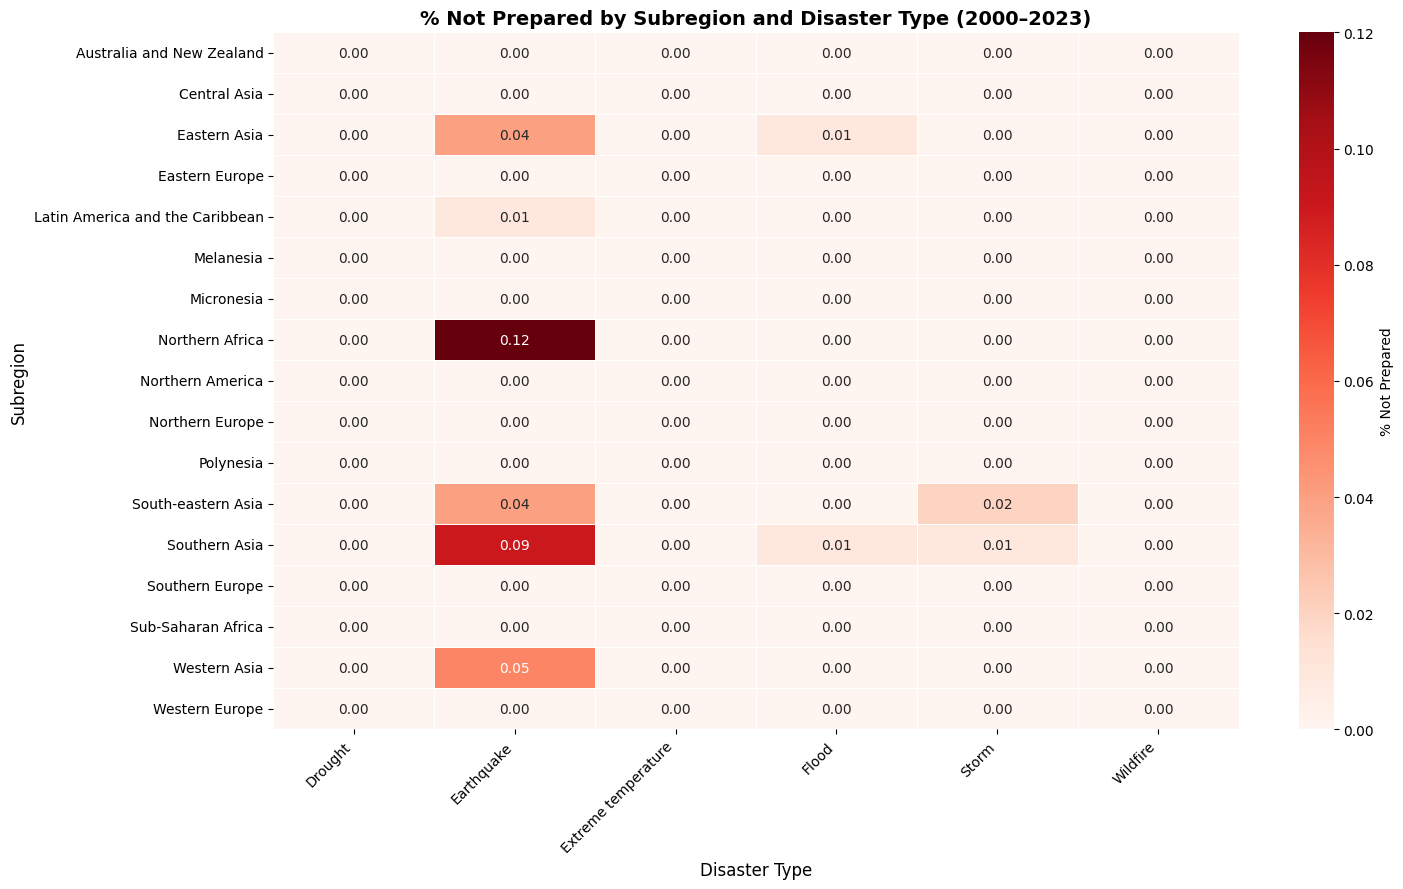

In [51]:
# Prepare data for heatmap: Pivot to show % Not Prepared by Subregion and Disaster Type
heatmap_df = prep_pivot.pivot_table(
    index='Subregion',
    columns='Disaster Type',
    values='% Not Prepared',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(15, 9))
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap='Reds',
    fmt=".2f",
    linewidths=0.6,
    linecolor='white',
    cbar_kws={'label': '% Not Prepared'}
)
plt.title('% Not Prepared by Subregion and Disaster Type (2000–2023)', fontsize=14, weight='bold')
plt.xlabel('Disaster Type', fontsize=12)
plt.ylabel('Subregion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save Figure
plt.savefig("heatmap_not_prepared_by_subregion_disaster_type.png", dpi=300)

plt.show()

**Description:**

This section visualizes the percentage of disaster events classified as “Not Prepared” across different subregions and disaster types between 2000 and 2023. The dataset was first aggregated and pivoted to calculate the proportion of unprepared responses for each disaster-subregion pair. The resulting matrix was then displayed using a heatmap, where darker red shades indicate higher percentages of unprepared responses. Lighter shades, conversely, indicate better relative preparedness.

**Interpretation of Results:**

The heatmap reveals notable disparities in disaster preparedness outcomes across subregions. For most subregions and disaster types, the proportion of “Not Prepared” responses remains very low or at zero, indicating relatively consistent engagement with at least some form of preparation. However, the darkest cells, such as those for earthquakes in **Northern Africa (12%) and earthquakes in Southern Asia (9%)**, suggest these areas are struggling more than others in coping with seismic events. Additionally, regions like **Eastern Asia, South-Eastern Asia, Southern Asia and Western Asia** show modest unpreparedness rates for certain disasters like floods and storms. Interestingly, in many Global North subregions, all values for unpreparedness remain at 0%, reflecting either higher state capacity, more efficient disaster risk reduction protocols, or simply fewer high-impact disasters overall.


**Connection to Research Question:**

This visualization contributes directly to the thesis objective of evaluating how effectively governments protect human rights during climate and disaster crises. Regions with higher rates of unpreparedness are more likely to experience failures in safeguarding the right to life, shelter, food, and security during such events. The clear concentration of unprepared responses in parts of the Global South (e.g., Northern Africa, Western Asia, South and Southeast Asia) suggests that government capacity, resource allocation, or infrastructure limitations may be putting populations at greater human rights risk during disasters. By highlighting where gaps are most prevalent and for which types of disasters, the analysis identifies priority areas for strengthening state preparedness to reduce vulnerability and uphold fundamental rights.

##**Trends in Earthquake Preparedness Over Time (2000-2023)**

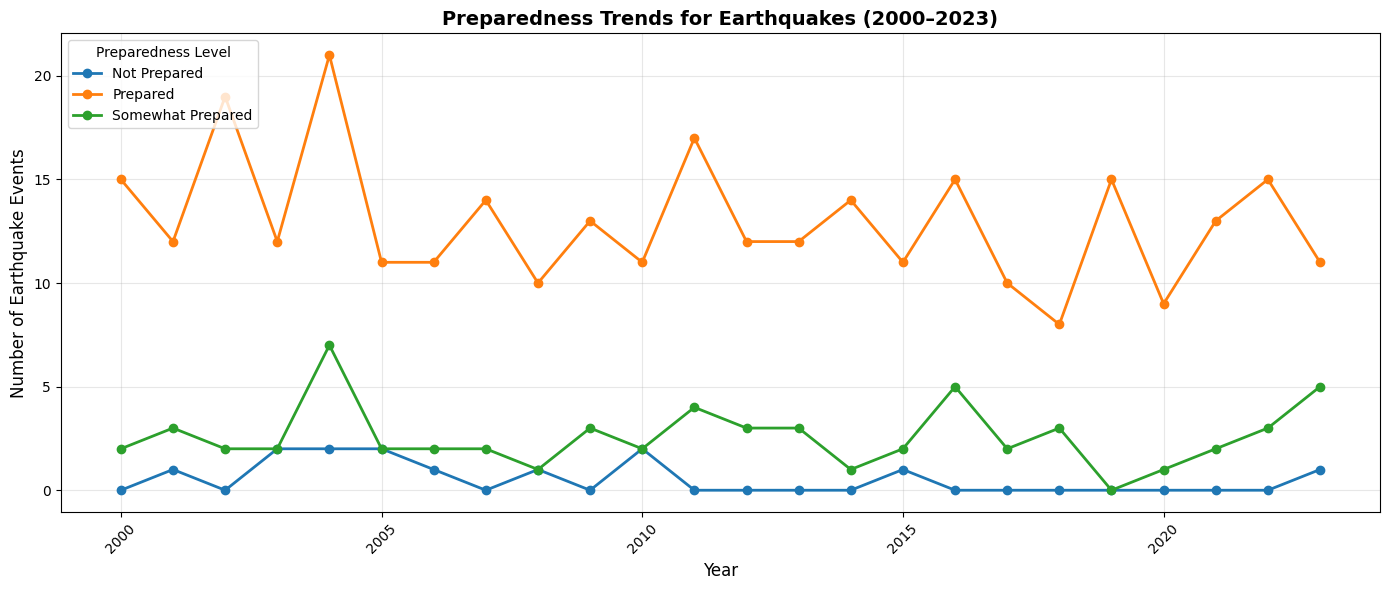

In [52]:
# Filter data for Earthquakes only
earthquake_df = df_prepared[df_prepared['Disaster Type'] == 'Earthquake']

# Group by Year and Preparedness Level
earthquake_yearly = (
    earthquake_df.groupby(['Year', 'Preparedness_Level_Enhanced'])
    .size()
    .reset_index(name='Count')
)

# Pivot table to reshape for line plotting
earthquake_trends = earthquake_yearly.pivot(
    index='Year',
    columns='Preparedness_Level_Enhanced',
    values='Count'
).fillna(0)

# Plot Earthquake Preparedness Trends
plt.figure(figsize=(14, 6))
earthquake_trends.plot(marker='o', linewidth=2, ax=plt.gca())

plt.title('Preparedness Trends for Earthquakes (2000–2023)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Earthquake Events', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(title='Preparedness Level', loc='upper left')
plt.tight_layout()

# Save figure
plt.savefig("earthquake_preparedness_trends_2000_2023.png", dpi=300)

plt.show()

**Description:**

This line chart illustrates annual trends in earthquake events from 2000 to 2023, disaggregated by the level of government preparedness: Prepared, Somewhat Prepared, and Not Prepared. The dataset was filtered for earthquake events only, then grouped by year and preparedness level to examine temporal patterns. Each line in the plot represents the yearly count of events falling into one of the three preparedness categories.

**Interpretation of Results**

The orange line, representing “Prepared” events, consistently dominates across the 24-year period, suggesting that earthquakes are more likely to trigger a prepared response from governments. However, the frequency of “Somewhat Prepared” events (green line) is not insignificant and appears to show some fluctuation, with peaks emerging in more recent years—indicating some variability or strain in full preparedness. Notably, the “Not Prepared” category (blue line) remains very low throughout, with only occasional instances. While this may reflect improved infrastructure or response systems, it could also result from underreporting or differing classification standards across countries.

**Connection to Research Question:**

This trend analysis contributes directly to the thesis objective of evaluating government preparedness for climate-related and geophysical disasters, and how such preparedness protects human rights. The consistent prevalence of “Prepared” responses to earthquakes supports the idea that certain disaster types may benefit from long-term institutional readiness (e.g., building codes, drills, early warning systems). However, the presence of “Somewhat Prepared” and “Not Prepared” cases indicates uneven capacities across countries or years. By identifying these patterns over time, the analysis helps evaluate whether disaster preparedness correlates with effective rights protection, and where gaps may still persist in the global response infrastructure.

## **Distribution of Human Rights Violation Risks in Disaster Events**

In [53]:
# Ensure the 'Rights_Violation_Risk' column is treated as string
df_prepared['Rights_Violation_Risk'] = df_prepared['Rights_Violation_Risk'].astype(str).str.strip()

# Count percentage distribution of rights violation risk
rights_counts = (
    df_prepared['Rights_Violation_Risk']
    .value_counts(normalize=True)
    .rename_axis('Rights_Violation_Risk')
    .reset_index(name='Percentage')
    .sort_values(by='Rights_Violation_Risk')  # Ensures 'No' appears before 'Yes'
)

# Round and format output
rights_counts['Percentage'] = rights_counts['Percentage'].mul(100).round(2)

# Save the rights violation risk distribution table as CSV
rights_counts.to_csv("Rights_Violation_Risk_Distribution.csv", index=False)

# Display results
print("Rights Violation Risk (%)")
print(rights_counts.to_string(index=False))

Rights Violation Risk (%)
Rights_Violation_Risk  Percentage
                 High       88.07
                  Low        0.97
           Low-Medium        2.72
               Medium        7.14
          Medium-High        1.11


**Description:**

This section presents the overall distribution of disaster events categorized by their associated risk of human rights violations. Using the Rights_Violation_Risk column, disaster events from 2000 to 2023 were grouped by risk severity levels such as “High,” “Medium,” “Low,” and their combinations (e.g., “Low–Medium,” “Medium–High”). The percentage of events in each risk category was calculated to provide a clearer understanding of how frequently disasters are linked with potential rights risks.

**Interpretation of Results:**

The results show that a significant majority of disaster events—**88.07%**—are associated with a high risk of human rights violations. Medium risk levels also make up a notable portion, with **7.14%**, while low risk and mixed risk categories (e.g., Low–Medium or Medium–High) represent much smaller shares. This suggests that human rights concerns are not only frequent but predominantly severe when they arise in the context of disasters. The minimal presence of events classified as “Low” risk **(0.97%)** further underscores the consistent vulnerability of affected populations.

**Connection to Research Question:**

This finding directly supports the research question, which seeks to evaluate how effectively governments protect fundamental human rights in regions prone to climate-related and natural disasters. The dominance of high-risk classifications suggests that many governments, particularly in disaster-prone areas, are failing to sufficiently safeguard rights like access to housing, food, healthcare, and security during and after disasters. This statistical baseline highlights the urgency of improving rights-protective measures as part of national preparedness frameworks—particularly in countries frequently affected by extreme weather events, earthquakes, or flooding.

##**Disaster Subtypes and Their Association with Human Rights Violation Risk**

In [54]:
# Group disaster events by Rights Violation Risk, Disaster Type, and Disaster Subtype
risk_disaster_subtype_counts = (
    df_prepared.groupby(['Rights_Violation_Risk', 'Disaster Type', 'Disaster Subtype'])
    .size()
    .reset_index(name='Event Count')
    .sort_values(['Rights_Violation_Risk', 'Event Count'], ascending=[True, False])
)

# Display side-by-side table with all columns clearly shown
pd.set_option('display.max_columns', None)      # Show all columns
pd.set_option('display.width', 150)             # Increase total print width
pd.set_option('display.colheader_justify', 'center')  # Center column headers

# Save the disaster subtypes and rights violation risk table
risk_disaster_subtype_counts.to_csv("Disaster_Subtypes_and_Rights_Risk.csv", index=False)

# Print the clean table
print(risk_disaster_subtype_counts.to_string(index=False))

Rights_Violation_Risk    Disaster Type        Disaster Subtype     Event Count
            High                    Flood          Riverine flood     1149    
            High                    Flood         Flood (General)      701    
            High                    Storm        Tropical cyclone      653    
            High                    Flood             Flash flood      510    
            High                  Drought                 Drought      391    
            High               Earthquake         Ground movement      357    
            High                    Flood           Coastal flood       34    
            High               Earthquake                 Tsunami       29    
             Low                    Storm                    Hail       42    
      Low-Medium                    Storm Lightning/Thunderstorms      118    
          Medium      Extreme temperature               Heat wave      216    
          Medium                    Storm           

**Description:**

This analysis breaks down disaster events by both **disaster type** and **disaster subtype**, while also categorizing them according to their **associated level of human rights violation risk** (e.g., High, Medium, Low, etc.). By grouping the data along these three dimensions—risk level, disaster type, and disaster subtype—we obtain a more granular understanding of which specific kinds of disasters are more frequently associated with heightened threats to human rights. The event counts reflect the frequency with which each combination has occurred in the dataset from 2000–2023.


**Interpretation of Results:**

The results reveal that **floods**, especially **riverine floods** and **general floods**, dominate the “High” rights violation risk category, with 1,149 and 701 events respectively. This highlights the significant impact of water-related disasters on populations’ rights, likely due to widespread displacement, loss of shelter, and health infrastructure collapse. **Storms** such as **tropical cyclones** (653 events) and **flash floods** (510 events) also appear prominently in the high-risk category. Earthquakes and tsunamis, while less frequent, still carry high risk, as shown by the presence of **ground movement** and **tsunami** subtypes in this category. In contrast, low-risk events such as **hail storms** and **lightning/thunderstorms** are more localized and less disruptive on a broad scale. Subtypes like **heat waves, tornadoes, and wildfires** tend to fall into the medium or medium-high risk range, suggesting variable impacts depending on location and severity.

**Connection to Research Question:**

This detailed categorization offers direct support for the thesis objective: assessing how well governments prepare for disasters in ways that safeguard fundamental human rights. By identifying which disaster subtypes are most strongly associated with high rights violation risks, the analysis helps pinpoint priority areas for policy intervention and preparedness improvement. For example, the dominance of high-risk riverine flooding and tropical cyclones indicates a need for robust evacuation planning, emergency shelter provisions, and infrastructure resilience in flood-prone regions. Understanding the granularity of disaster impacts by subtype deepens the insight into where preparedness must be targeted to better protect rights like housing, health, and access to aid—core concerns of the research.

##**Disaster Subtypes and the Specific Human Rights They Threaten**

In [55]:
# Define the rights mapping by disaster subtype
rights_mapping = {
    'Riverine flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Flash flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Coastal flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Flood (General)': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],

    'Tropical cyclone': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Storm (General)': ['Right to Shelter', 'Right to Aid'],
    'Tornado': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Hail': ['Right to Health'],
    'Lightning/Thunderstorms': ['Right to Life', 'Right to Health', 'Right to Shelter'],

    'Ground movement': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health'],
    'Earthquake': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Tsunami': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health', 'Right to Education'],

    'Wildfire (General)': ['Right to Life', 'Right to Shelter', 'Right to a Healthy Environment', 'Right to Health'],
    'Heat wave': ['Right to Life', 'Right to Health', 'Right to a Healthy Environment'],
    'Drought': ['Right to Food', 'Right to Water', 'Right to Health'],
    'Sand/Dust storm': ['Right to Health', 'Right to a Healthy Environment'],

    'Extreme temperature (other)': ['Right to Health', 'Right to Life']
}

# Apply mapping to create a new column
def get_rights(subtype):
    return ', '.join(rights_mapping.get(subtype, ['Unknown']))

df_prepared['Rights_Impacted'] = df_prepared['Disaster Subtype'].apply(get_rights)

# Group by all relevant dimensions
risk_disaster_rights = (
    df_prepared.groupby(['Rights_Violation_Risk', 'Disaster Type', 'Disaster Subtype', 'Rights_Impacted'])
    .size()
    .reset_index(name='Event Count')
    .sort_values(['Rights_Violation_Risk', 'Event Count'], ascending=[True, False])
)

# Save disaster subtypes and associated rights impacts table
risk_disaster_rights.to_csv("Disaster_Subtypes_and_Rights_Impacted.csv", index=False)

# Display the clean table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.colheader_justify', 'center')

print(risk_disaster_rights.to_string(index=False))

Rights_Violation_Risk    Disaster Type        Disaster Subtype                                             Rights_Impacted                                            Event Count
            High                    Flood          Riverine flood                     Right to Life, Right to Shelter, Right to Water, Right to Aid, Right to Health     1149    
            High                    Flood         Flood (General)                     Right to Life, Right to Shelter, Right to Water, Right to Aid, Right to Health      701    
            High                    Storm        Tropical cyclone                 Right to Life, Right to Shelter, Right to Aid, Right to Health, Right to Education      653    
            High                    Flood             Flash flood                     Right to Life, Right to Shelter, Right to Water, Right to Aid, Right to Health      510    
            High                  Drought                 Drought                                             

Visualization

In [56]:
# Explode the Rights_Impacted field
df_prepared['Rights_Impacted_List'] = df_prepared['Rights_Impacted'].str.split(', ')
df_exploded_rights = df_prepared.explode('Rights_Impacted_List')

# Count frequency of each right per disaster subtype
rights_by_disaster_subtype = (
    df_exploded_rights
    .groupby(['Disaster Subtype', 'Rights_Impacted_List'])
    .size()
    .reset_index(name='Event Count')
)

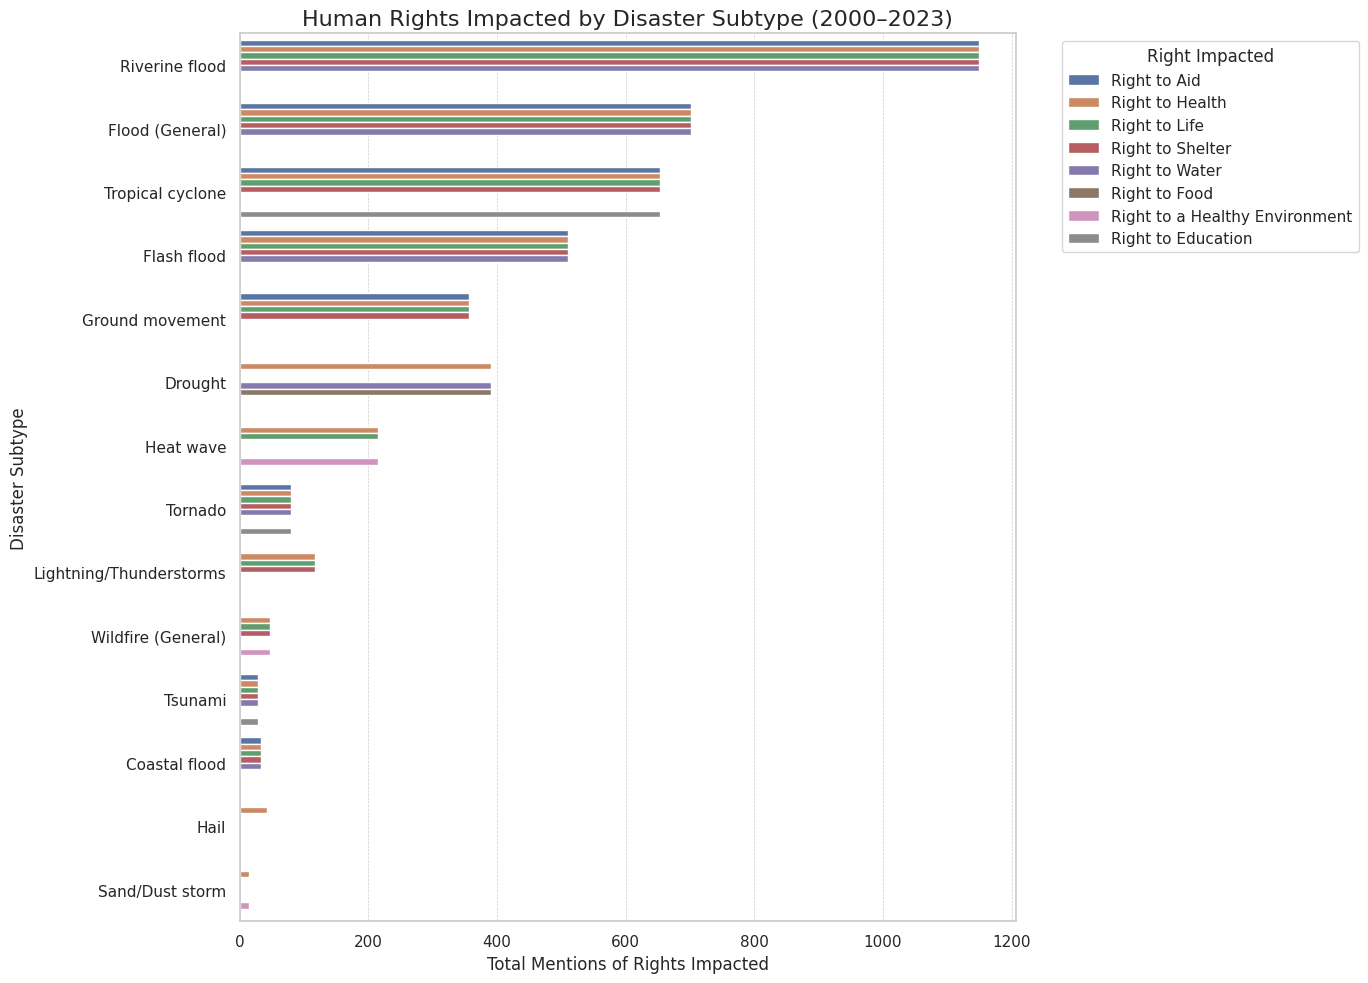

In [57]:
# Set plot style
sns.set(style="whitegrid")

# Order subtypes by total count
ordered_subtypes = (
    rights_by_disaster_subtype
    .groupby('Disaster Subtype')['Event Count']
    .sum()
    .sort_values(ascending=False)
    .index
)

# Create the horizontal barplot with enhanced spacing
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=rights_by_disaster_subtype,
    y='Disaster Subtype',
    x='Event Count',
    hue='Rights_Impacted_List',
    order=ordered_subtypes,
    dodge=True
)

# Improve layout
plt.title('Human Rights Impacted by Disaster Subtype (2000–2023)', fontsize=16)
plt.xlabel('Total Mentions of Rights Impacted', fontsize=12)
plt.ylabel('Disaster Subtype', fontsize=12)
plt.legend(title='Right Impacted', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add gridlines and adjust spacing
plt.grid(True, axis='x', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0)
plt.tight_layout()


# Save the figure
plt.savefig("Human_Rights_by_Disaster_Subtype.png", dpi=300, bbox_inches='tight')

plt.show()


**Description:**

This section expands the analysis of disaster events by linking each disaster subtype to the specific human rights it most likely impacts. A custom mapping was applied to identify how different disaster types—such as floods, earthquakes, storms, and heat waves—threaten rights like the right to life, shelter, water, food, health, aid, education, and a healthy environment. The dataset was grouped by rights violation risk, disaster type, subtype, and the corresponding rights impacted, producing a rich and detailed table showing the frequency and nature of these risks.

**Interpretation of Results:**

The results clearly show that certain disaster subtypes are consistently associated with a wide spectrum of human rights risks. For example, **riverine floods and flash floods**, which fall under the **‘High’ risk** category, frequently affect the **right to life, shelter, water, aid, and health**. Similarly, **tropical cyclones and tsunamis** emerge as major multi-right threats, with **education rights** also appearing due to their infrastructure-disrupting nature. **Wildfires, droughts, and extreme temperatures** show strong associations with **environmental and health rights**, while **sand/dust storms** and **hail events** are more narrowly linked to **health-related risks**. This multi-layered grouping not only quantifies the severity of threats but clarifies which rights are at stake for each disaster subtype.


**Connection to Research Question:**

By explicitly linking disaster subtypes to the specific human rights they endanger, this analysis strengthens the foundation of the research question: **How effectively do governments protect fundamental human rights in disaster-prone regions, and how can data science assess and improve preparedness?** The breakdown illustrates that the type of disaster—not just its occurrence—matters immensely when evaluating rights risk.

##**Human Rights Impacted by Disaster Events Across Subregions (2000-2023)**

In [59]:
# Group by Subregion, Disaster Type, Subtype, and Rights Impacted
subregion_disaster_rights = (
    df_prepared.groupby(['Subregion', 'Disaster Type', 'Disaster Subtype', 'Rights_Impacted'])
    .size()
    .reset_index(name='Event Count')
    .sort_values(['Subregion', 'Event Count'], ascending=[True, False])
)

# Display the full table cleanly
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.colheader_justify', 'center')

# Show the results
print(subregion_disaster_rights.to_string(index=False))

           Subregion               Disaster Type        Disaster Subtype                                             Rights_Impacted                                            Event Count
      Australia and New Zealand               Flood         Flood (General)                     Right to Life, Right to Shelter, Right to Water, Right to Aid, Right to Health      14     
      Australia and New Zealand               Flood          Riverine flood                     Right to Life, Right to Shelter, Right to Water, Right to Aid, Right to Health      14     
      Australia and New Zealand               Storm        Tropical cyclone                 Right to Life, Right to Shelter, Right to Aid, Right to Health, Right to Education      13     
      Australia and New Zealand               Flood             Flash flood                     Right to Life, Right to Shelter, Right to Water, Right to Aid, Right to Health       8     
      Australia and New Zealand               Storm Lightnin

In [61]:
# Export to CSV
subregion_disaster_rights.to_csv("rights_impacted_by_disaster_and_subregion.csv", index=False)

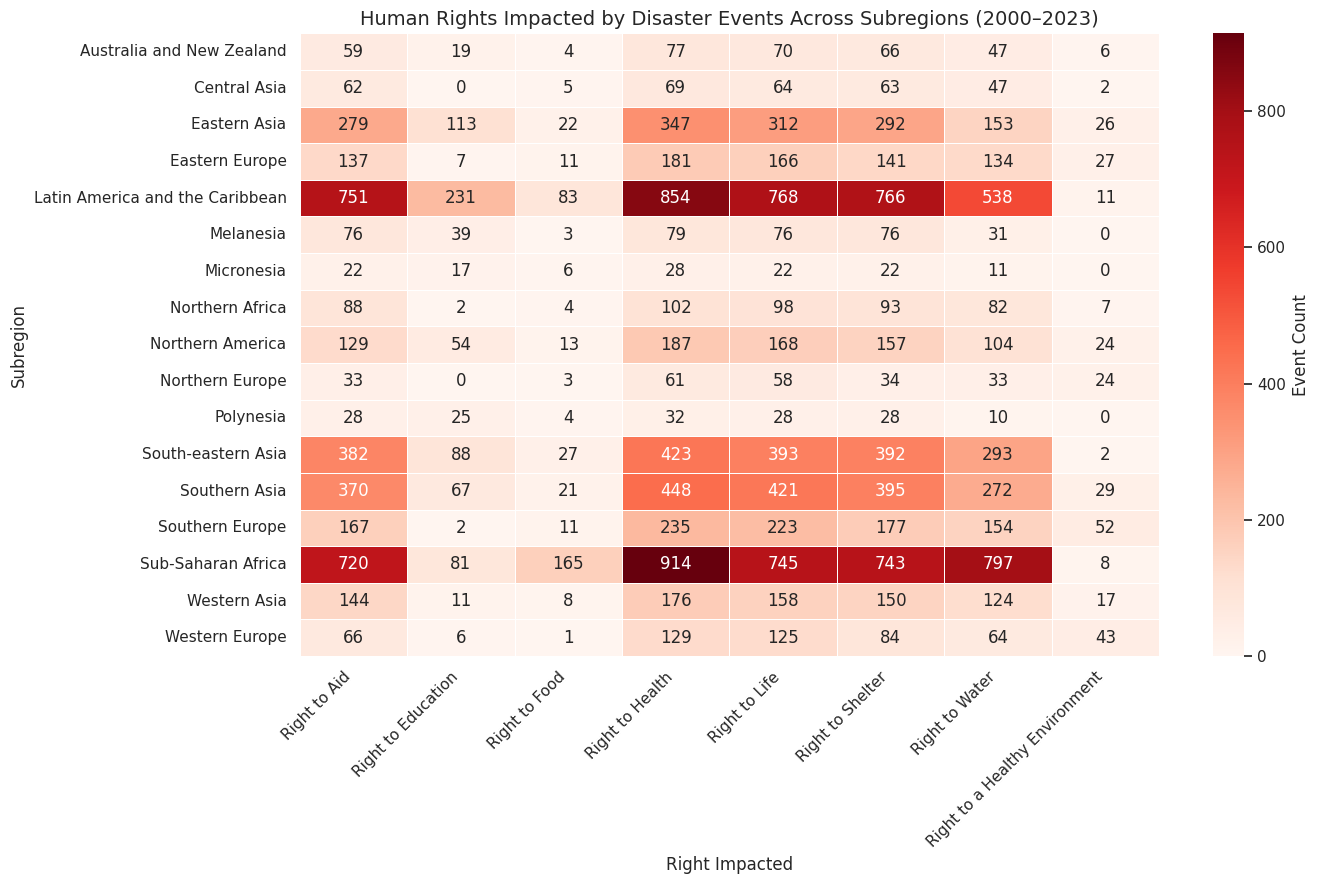

In [62]:
# Explode the Rights_Impacted column into separate rows (1 row per right)
df_rights_exploded = df_prepared.copy()
df_rights_exploded['Rights_Impacted_List'] = df_rights_exploded['Rights_Impacted'].str.split(', ')
df_rights_exploded = df_rights_exploded.explode('Rights_Impacted_List')

# Group by Subregion and Right, then count
rights_by_subregion = (
    df_rights_exploded.groupby(['Subregion', 'Rights_Impacted_List'])
    .size()
    .reset_index(name='Event Count')
)

# Pivot to wide format for heatmap
heatmap_data = rights_by_subregion.pivot(index='Subregion', columns='Rights_Impacted_List', values='Event Count').fillna(0)

# Plot the heatmap
plt.figure(figsize=(14, 9))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='Reds', linewidths=0.5, cbar_kws={'label': 'Event Count'})
plt.title('Human Rights Impacted by Disaster Events Across Subregions (2000–2023)', fontsize=14)
plt.xlabel('Right Impacted', fontsize=12)
plt.ylabel('Subregion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save Figure
plt.savefig("rights_impacted_by_subregion_heatmap.png", dpi=300)

plt.show()

**Description:**

This visualization presents a heatmap illustrating the extent to which disaster events have impacted fundamental human rights across global subregions between 2000 and 2023. Each cell in the heatmap represents the number of disaster events in which a specific human right—such as the right to life, shelter, or health—was at risk within a given subregion. To create this view, disaster subtypes were systematically mapped to the rights they most likely affect, and the dataset was transformed to account for multiple rights being impacted per event. The heatmap provides a comprehensive, disaggregated overview of how disasters translate into human rights vulnerabilities, offering an empirical lens to compare the frequency and distribution of rights at risk across different world regions.

**Interpretation of Results:**

The heatmap reveals stark regional disparities in disaster-driven human rights threats. Subregions such as **Latin America and the Caribbean**, **Sub-Saharan Africa, South-Eastern Asia, Southern Asia and Eastern Asia **experienced the highest frequencies of rights being impacted. In **Latin America and the Caribbean**, for example, the **right to aid, health, life, shelter, and water** repeatedly affected—each surpassing 500+ instances over the two-decade span.

**Connection to Research Question:**

This visualization directly supports the thesis question on how effectively governments protect fundamental human rights in the face of climate disasters. It illustrates not only which regions are at greater risk of rights violations, but also identifies the specific rights most frequently threatened. By disaggregating the impact across rights and locations, the analysis provides actionable insights into where global and regional preparedness efforts must improve.

##**Top 20 Countries with the Highest Human Rights Impacts from Disaster Events (2000-2023)**

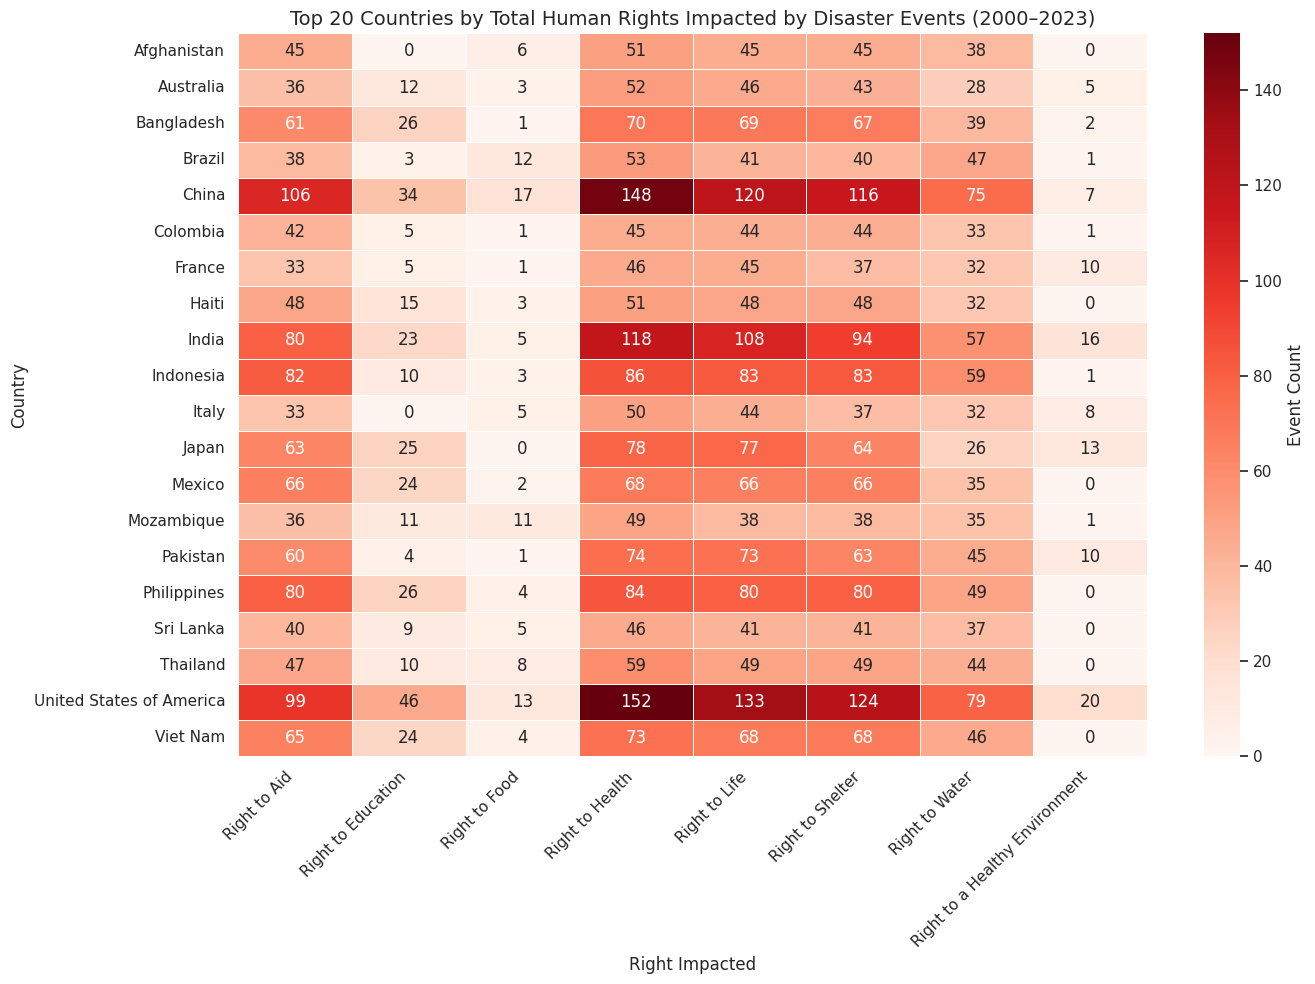

In [63]:
# Explode rights impacted list
df_country_exploded = df_prepared.copy()
df_country_exploded['Rights_Impacted_List'] = df_country_exploded['Rights_Impacted'].str.split(', ')
df_country_exploded = df_country_exploded.explode('Rights_Impacted_List')

# Group by country and right to count total impacts
rights_by_country = (
    df_country_exploded
    .groupby(['Country', 'Rights_Impacted_List'])
    .size()
    .reset_index(name='Event Count')
)

# Get top 20 countries with highest total human rights impacts
top_countries = (
    rights_by_country
    .groupby('Country')['Event Count']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .index
)

# Filter data to top countries
rights_by_top_countries = rights_by_country[rights_by_country['Country'].isin(top_countries)]

# Pivot for heatmap
heatmap_country_data = rights_by_top_countries.pivot(
    index='Country',
    columns='Rights_Impacted_List',
    values='Event Count'
).fillna(0)

# Plot heatmap with annotations
plt.figure(figsize=(14, 10))
sns.heatmap(
    heatmap_country_data,
    annot=True,
    fmt='.0f',
    cmap='Reds',
    linewidths=0.5,
    cbar_kws={'label': 'Event Count'}
)
plt.title('Top 20 Countries by Total Human Rights Impacted by Disaster Events (2000–2023)', fontsize=14)
plt.xlabel('Right Impacted', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save figure
plt.savefig("top20_countries_rights_impacted_heatmap.png", dpi=300)

plt.show()

**Description:**

This section presents a heatmap visualization of the countries where disasters most frequently impacted fundamental human rights. The heatmap is constructed by first identifying and exploding each rights violation reported per disaster event, and then aggregating these occurrences by country. The top 20 countries were selected based on the total number of rights-impacted instances recorded across all disaster events from 2000 to 2023. Each row in the heatmap represents a country, and each column corresponds to a specific human right (e.g., life, shelter, aid). Cell values indicate the number of disaster events that impacted that specific right in the corresponding country.


**Interpretation of Results:**

The results reveal substantial geographic variation in the frequency of human rights violations resulting from disaster events. Countries such as **China, India, and the United States** stand out with the highest number of rights-impacted instances across several categories, particularly the **right to life, shelter, health and aid**. This may reflect both the severity and recurrence of disaster types in these regions, as well as systemic vulnerabilities in emergency preparedness and state response mechanisms. Some countries like **Indonesia** and **Philippines** also rank high in relative terms despite having fewer total events, indicating disproportionately severe outcomes when disasters occur. The consistent appearance of rights like shelter, water, and aid across countries suggests these are particularly fragile domains in disaster contexts.

**Connection to Research Question:**

This analysis directly addresses the thesis research question: **“How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?”** By quantifying and comparing rights violations at the country level, this visualization highlights critical areas of risk and underprotection. It provides empirical evidence of where state systems may be failing to uphold rights in disaster contexts and can guide to identify and prioritize interventions where rights are most at risk.

##**Mapping Global Human Rights Impacts from Disasters (2000-2023)**

In [ ]:
# Explode Rights_Impacted to get one row per right per disaster
df_exploded = df_prepared.copy()
df_exploded['Rights_Impacted_List'] = df_exploded['Rights_Impacted'].str.split(', ')
df_exploded = df_exploded.explode('Rights_Impacted_List')

# Count total human rights impacts per country
country_rights_counts = (
    df_exploded.groupby('Country')
    .size()
    .reset_index(name='Total_Human_Rights_Impacted')
)

# Plot the choropleth
fig = px.choropleth(
    country_rights_counts,
    locations='Country',
    locationmode='country names',
    color='Total_Human_Rights_Impacted',
    color_continuous_scale='Reds',
    title='Total Human Rights Impacts by Disaster Events (2000–2023)',
    labels={'Total_Human_Rights_Impacted': 'HR Impacts'},
)

# Optional map tweaks
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False),
    coloraxis_colorbar=dict(title='Number of Rights Impacted'),
)

fig.show()

**Description:**

This choropleth map visualizes the total number of human rights impacts attributed to disaster events across countries between 2000 and 2023. The metric represents the cumulative count of rights affected (e.g., right to life, shelter, health, etc.) due to various disaster subtypes within each country. Darker shades of red indicate a higher total of reported rights impacts, providing a comparative global view of human rights vulnerability to disasters.

The data was generated by disaggregating each disaster event into individual rights impacted and aggregating counts at the country level. Plotly was used to render the interactive map for enhanced geographical analysis.

**Interpretation of Results:**

From the map, several regions emerge as major hotspots for disaster-driven human rights challenges. Countries like India, China, the United States, appear in the darkest shades, reflecting both high disaster frequency and the widespread effects on multiple rights domains. These may include recurring floods, earthquakes, cyclones, wildfires, or droughts that lead to significant challenges in securing life, shelter, health, and aid.

Conversely, lighter regions—often smaller countries or those with fewer recorded disaster impacts—show minimal aggregated rights violations, though this may also reflect data limitations rather than true absence of harm.

This visualization underscores not only which countries experience frequent and severe disasters but also where the human consequences of those disasters accumulate most heavily over time.

**Connection to Research Question:**

This analysis directly supports the thesis research question:
**“How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?”**

By highlighting where disaster-related rights violations are most prevalent, the map helps identify geographic concentrations of vulnerability.

##**Preparedness vs. Human Rights Impacts at the Country Level (2000-2023)**

In [64]:
df_prepared['Preparedness_Score'] = df_prepared.apply(calculate_preparedness_score, axis=1)

def classify_preparedness(score):
    if score >= 4:
        return 'Not Prepared'
    elif score >= 2:
        return 'Somewhat Prepared'
    else:
        return 'Prepared'

df_prepared['Preparedness_Level_Enhanced'] = df_prepared['Preparedness_Score'].apply(classify_preparedness)

In [65]:
# Explode Rights_Impacted into separate rows
df_exploded = df_prepared.copy()
df_exploded['Rights_Impacted_List'] = df_exploded['Rights_Impacted'].str.split(', ')
df_exploded = df_exploded.explode('Rights_Impacted_List')

# Count number of rights impacted per country
rights_count_by_country = (
    df_exploded.groupby('Country')
    .size()
    .reset_index(name='Total_Human_Rights_Impacted')
)

# Count number of disasters per preparedness level per country
preparedness_by_country = (
    df_prepared.groupby(['Country', 'Preparedness_Level_Enhanced'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Merge both
summary_table = pd.merge(preparedness_by_country, rights_count_by_country, on='Country')

# Sort by most rights impacted
summary_table = summary_table.sort_values(by='Total_Human_Rights_Impacted', ascending=False)

# Display cleanly
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)
pd.set_option('display.colheader_justify', 'center')

# Save Preparedness vs. Human Rights Impacts summary table
summary_table.to_csv("Preparedness_vs_Human_Rights_Impacts.csv", index=False)

# Show final summary table
print(summary_table.to_string(index=False))

                      Country                         Not Prepared  Prepared  Somewhat Prepared  Total_Human_Rights_Impacted
                            United States of America       0          142            10                     666             
                                               China       3           99            46                     623             
                                               India       4           67            47                     501             
                                           Indonesia       2           57            27                     407             
                                         Philippines       1           61            22                     403             
                                            Viet Nam       0           56            17                     348             
                                               Japan       0           70             8                     346             


**Description:**

This table summarizes, for each country, the number of disaster events categorized by preparedness level—Prepared, Somewhat Prepared, or Not Prepared—alongside the total number of human rights impacts observed during these events. The human rights impacts are derived from disaster subtype mappings linked to specific rights such as the right to life, shelter, water, health, food, aid, education, and a healthy environment. The goal is to examine the relationship between disaster preparedness and the scale of human rights risks experienced by countries over the 2000–2023 period.

**Interpretation of Results:**

While countries like the **United States, China,** and **India** had a large share of disaster events labeled as Prepared, they also show **high numbers of human rights impacts**, with the U.S. topping the list at 666 impacts. This challenges the assumption that preparedness alone guarantees protection of rights. For example, **Japan** had a majority of events marked Prepared, yet still recorded 346 rights impacts. In contrast, countries with relatively fewer events or more consistent preparedness tend to show moderately lower rights risks.

Interestingly, countries with more Somewhat Prepared or Not Prepared events—like **Pakistan, Afghanistan**, and **Haiti**—also show significant human rights impacts, suggesting that **low preparedness likely exacerbates rights vulnerability**. However, high preparedness does not fully shield countries from rights risks, potentially due to the **magnitude of disasters, population vulnerability, or insufficient protection mechanisms despite operational readiness**.

**Connection to Research Question:**

This analysis adds nuance to the core research question:

**“How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?”**

The results reveal that **higher levels of preparedness do not necessarily correlate with lower human rights impacts**. Countries like the United States, China, and India, which report a large number of Prepared disaster responses, still experience some of the **highest levels of human rights violations**. This indicates that **preparedness, as currently measured or implemented, does not guarantee protection of human rights** during disasters.

##**Disaggregating Rights Risks by Subregion: A Granular View of Human Rights Exposure**

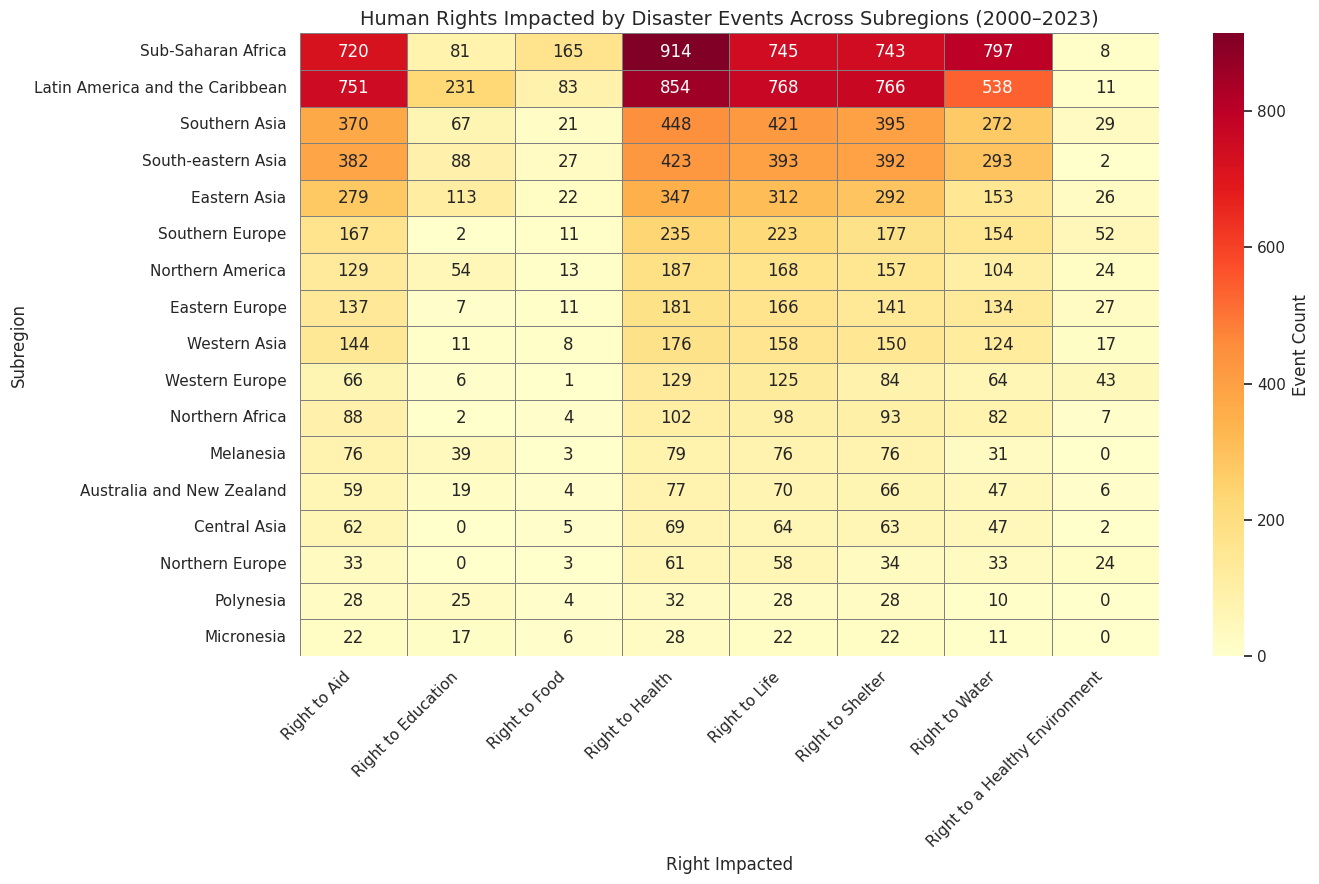

In [66]:
# Define the rights mapping by disaster subtype
rights_mapping = {
    'Riverine flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Flood (General)': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Flash flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Coastal flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],

    'Tropical cyclone': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Storm (General)': ['Right to Shelter', 'Right to Aid'],
    'Tornado': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Hail': ['Right to Health'],
    'Lightning/Thunderstorms': ['Right to Life', 'Right to Health', 'Right to Shelter'],

    'Ground movement': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health'],
    'Earthquake': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Tsunami': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health', 'Right to Education'],

    'Wildfire (General)': ['Right to Life', 'Right to Shelter', 'Right to a Healthy Environment', 'Right to Health'],
    'Heat wave': ['Right to Life', 'Right to Health', 'Right to a Healthy Environment'],
    'Drought': ['Right to Food', 'Right to Water', 'Right to Health'],
    'Sand/Dust storm': ['Right to Health', 'Right to a Healthy Environment'],
    'Extreme temperature (other)': ['Right to Health', 'Right to Life']
}

# Apply the mapping to create a new column of rights impacted
def get_rights(subtype):
    return ', '.join(rights_mapping.get(subtype, ['Unknown']))

df_prepared['Rights_Impacted'] = df_prepared['Disaster Subtype'].apply(get_rights)

# Split the Rights_Impacted string into a list
df_prepared['Rights_Impacted_List'] = df_prepared['Rights_Impacted'].str.split(', ')

# Explode the rights list into individual rows
df_exploded = df_prepared.explode('Rights_Impacted_List')

# Group by Subregion and Right to count frequency
rights_by_subregion = (
    df_exploded.groupby(['Subregion', 'Rights_Impacted_List'])
    .size()
    .reset_index(name='Event Count')
)

# Pivot to wide format for heatmap
pivot_table_subregion = rights_by_subregion.pivot(
    index='Subregion',
    columns='Rights_Impacted_List',
    values='Event Count'
).fillna(0)

# Sort subregions by total rights impact
pivot_table_subregion = pivot_table_subregion.loc[
    pivot_table_subregion.sum(axis=1).sort_values(ascending=False).index
]

# Plot the heatmap
plt.figure(figsize=(14, 9))
sns.heatmap(
    pivot_table_subregion,
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    annot=True,
    fmt=".0f",
    cbar_kws={'label': 'Event Count'}
)
plt.title('Human Rights Impacted by Disaster Events Across Subregions (2000–2023)', fontsize=14)
plt.xlabel('Right Impacted', fontsize=12)
plt.ylabel('Subregion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("Human_Rights_by_Subregion.png", dpi=300, bbox_inches='tight')

plt.show()

**Description:**

To better understand how specific human rights are threatened across different parts of the world, this section presents a disaggregated analysis of rights impacts by subregion. Using the manually constructed Rights_Impacted variable from the disaster-rights mapping schema, each disaster event was associated with one or more fundamental rights at risk. These rights were then exploded into individual rows and aggregated by subregion to quantify the frequency with which each right was threatened. The results are visualized in a heatmap, where darker colors indicate higher exposure to specific rights violations.

**Interpretation of Results:**

The heatmap reveals distinct regional patterns in human rights vulnerability. **Sub-Saharan Africa and Latin America and the Caribbean** exhibit the highest overall exposure across nearly all rights, with particularly intense threats to the **Right to Health, Right to Life, and Right to Shelter**. **Southern and South-Eastern Asia** follow closely, also showing substantial counts across multiple rights. In contrast, regions such as **Micronesia, Northern Europe, and Polynesia** display far fewer rights threats, often limited to specific categories such as the **Right to Health or Right to Water**. Notably, the Right to Education is among the least frequently impacted across all regions, whereas **Health, Aid, and Life** emerge as consistently high-risk categories in disaster-prone contexts.

**Connection to Research Question:**

These findings deepen the analysis of the thesis’ central research question—How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?—by demonstrating that rights risks are not uniformly distributed across the globe. Instead, they cluster by geography and hazard type, reflecting disparities in institutional capacity and vulnerability. This subregional breakdown enhances the preparedness framework by adding granularity to the human rights component, allowing for more targeted assessments of government performance and areas where intervention may be most urgently needed.

In [67]:
# Group by country and subregion
subregion_country_rights = (
    df_exploded.groupby(['Country', 'Subregion'])
    .size()
    .reset_index(name='Total_Human_Rights_Impacted')
)

# Plot the choropleth
fig_subregion_map = px.choropleth(
    subregion_country_rights,
    locations='Country',
    locationmode='country names',
    color='Total_Human_Rights_Impacted',
    color_continuous_scale='Reds',
    title='Total Human Rights Impacts by Disaster Events (2000–2023) – Subregion Aggregation',
    labels={'Total_Human_Rights_Impacted': 'HR Impacts'}
)

fig_subregion_map.update_geos(showframe=False, showcoastlines=False)
fig_subregion_map.update_layout(coloraxis_colorbar={'title': 'HR Impacts'})
fig_subregion_map.show()

##**Disaggregating Rights Risks by Region: A Granular View of Human Rights Exposure**

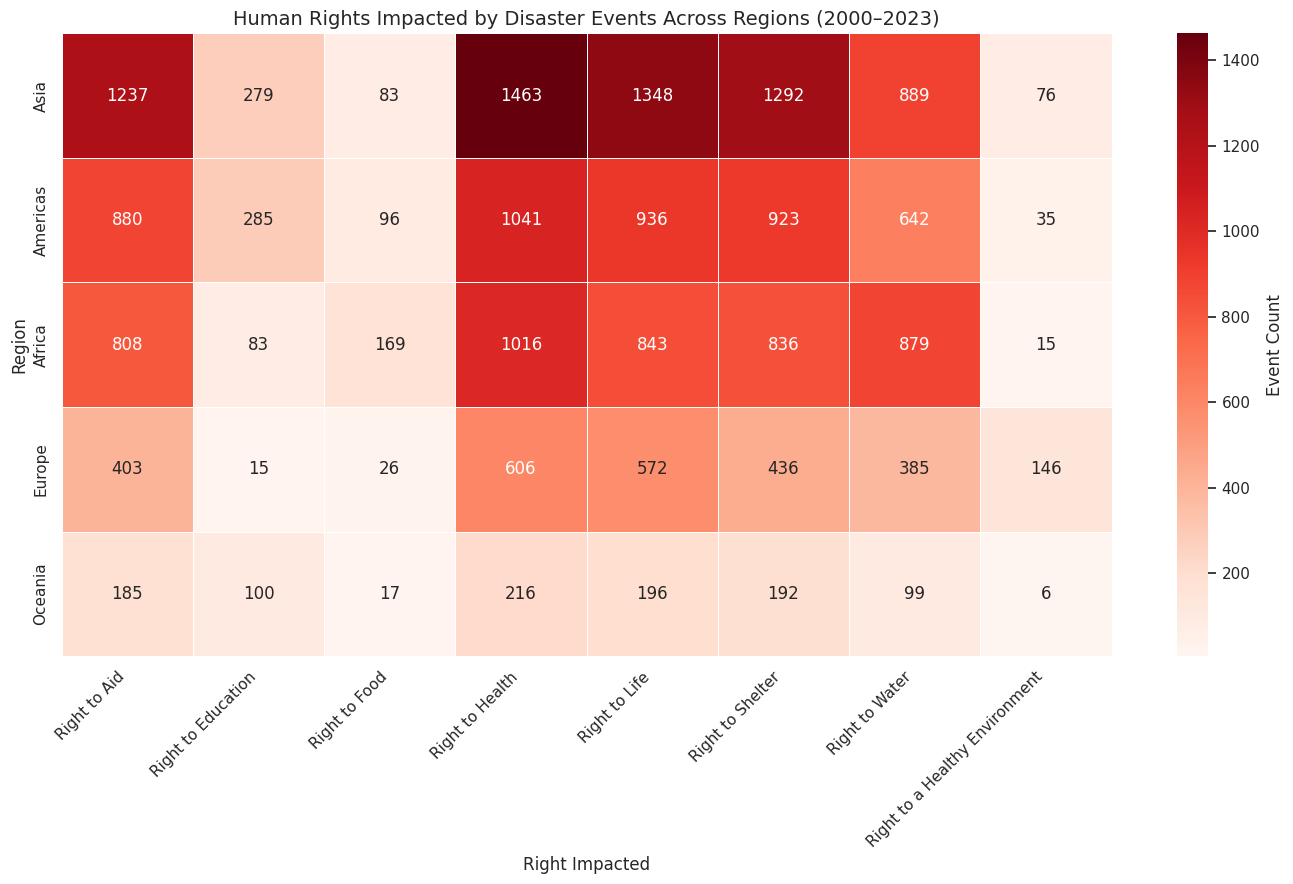

In [68]:
# Define the rights mapping based on Disaster Subtype
rights_mapping = {
    'Riverine flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Flood (General)': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Flash flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Coastal flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],

    'Tropical cyclone': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Storm (General)': ['Right to Shelter', 'Right to Aid'],
    'Tornado': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Hail': ['Right to Health'],
    'Lightning/Thunderstorms': ['Right to Life', 'Right to Health', 'Right to Shelter'],

    'Ground movement': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health'],
    'Earthquake': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Tsunami': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health', 'Right to Education'],

    'Wildfire (General)': ['Right to Life', 'Right to Shelter', 'Right to a Healthy Environment', 'Right to Health'],
    'Heat wave': ['Right to Life', 'Right to Health', 'Right to a Healthy Environment'],
    'Drought': ['Right to Food', 'Right to Water', 'Right to Health'],
    'Sand/Dust storm': ['Right to Health', 'Right to a Healthy Environment'],
    'Extreme temperature (other)': ['Right to Health', 'Right to Life']
}

# Function to map disaster subtypes to rights
def get_rights(subtype):
    return ', '.join(rights_mapping.get(subtype, ['Unknown']))

# Apply the mapping to create the Rights_Impacted column
df_prepared['Rights_Impacted'] = df_prepared['Disaster Subtype'].apply(get_rights)

# Explode the Rights_Impacted column into individual rights
df_prepared['Rights_Impacted_List'] = df_prepared['Rights_Impacted'].str.split(', ')
df_exploded = df_prepared.explode('Rights_Impacted_List')

# Group by Region and Right to count frequency
rights_by_region = (
    df_exploded.groupby(['Region', 'Rights_Impacted_List'])
    .size()
    .reset_index(name='Event Count')
)

# Pivot to wide format
heatmap_data_region = rights_by_region.pivot(
    index='Region',
    columns='Rights_Impacted_List',
    values='Event Count'
).fillna(0)

# Sort regions by total impact
heatmap_data_region = heatmap_data_region.loc[heatmap_data_region.sum(axis=1).sort_values(ascending=False).index]

# Plot heatmap
plt.figure(figsize=(14, 9))
sns.heatmap(
    heatmap_data_region,
    annot=True,
    fmt='.0f',
    cmap='Reds',
    linewidths=0.5,
    cbar_kws={'label': 'Event Count'}
)
plt.title('Human Rights Impacted by Disaster Events Across Regions (2000–2023)', fontsize=14)
plt.xlabel('Right Impacted', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save The Figure
plt.savefig("Human_Rights_by_Region.png", dpi=300, bbox_inches='tight')

plt.show()

**Description:**

To understand how the human rights impacts of climate-related disasters differ across world regions, this section visualizes the frequency with which specific rights were threatened in Africa, Asia, Europe, Oceania, and the Americas between 2000 and 2023. Using a custom rights mapping applied to disaster subtypes, each disaster was associated with one or more rights at risk—such as the right to life, shelter, health, or education. These associations were then exploded and aggregated by region to generate a heatmap of rights exposure. The visualization captures not only the severity but also the diversity of rights threatened across different geographies.

**Interpretation of Results:**

The heatmap reveals that Africa faces the most severe and widespread rights exposure, with consistently high counts across all major rights, especially the **Right to Health (1,463), Right to Life (1,248), and Right to Shelter (1,292)**. **Asia** closely follows, also exhibiting intense risk concentrations, particularly in the domains of health and life. **The Americas** show a comparable profile to Asia in total volume, but with slightly lower frequency across rights categories. **Europe** demonstrates more moderate levels of risk, yet still records substantial threats, especially to the rights to shelter, life, and water. **Oceania**, while experiencing fewer disasters in total, shows concentrated impacts in specific categories, including health and education. Overall, the results underscore a clear **regional gradient in rights vulnerability**, reflecting disparities in exposure, institutional capacity, and hazard types.

**Connection to Research Question:**

These findings contribute directly to the thesis’ central inquiry—How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?—by demonstrating that the **type and frequency of rights at risk vary significantly by region**. This reinforces the need for **context-sensitive preparedness strategies** and targeted policy interventions that align with regional risk profiles. The ability to visualize rights risk at the regional level enhances both the **diagnostic** and **monitoring capabilities** of the rights-based preparedness framework proposed in this thesis, and provides a scalable, data-driven lens for evaluating global governance in the face of climate emergencies.

In [69]:
# Map each country to its region
region_country_rights = (
    df_exploded.groupby(['Country', 'Region'])
    .size()
    .reset_index(name='Total_Human_Rights_Impacted')
)

# Create country-level choropleth using region totals
fig_region_map = px.choropleth(
    region_country_rights,
    locations='Country',
    locationmode='country names',
    color='Total_Human_Rights_Impacted',
    color_continuous_scale='Reds',
    title='Total Human Rights Impacts by Disaster Events (2000–2023) – Region Aggregation',
    labels={'Total_Human_Rights_Impacted': 'HR Impacts'}
)

fig_region_map.update_geos(showframe=False, showcoastlines=False)
fig_region_map.update_layout(coloraxis_colorbar={'title': 'HR Impacts'})
fig_region_map.show()

In [70]:
# Get the exploded rights dataset ready (if not already)
df_exploded = df_prepared.copy()
df_exploded['Rights_Impacted_List'] = df_exploded['Rights_Impacted'].str.split(', ')
df_exploded = df_exploded.explode('Rights_Impacted_List')

# Get list of unique rights
unique_rights = df_exploded['Rights_Impacted_List'].unique()

import plotly.express as px

# Loop through each right and plot a map
for right in unique_rights:
    df_right_map = (
        df_exploded[df_exploded['Rights_Impacted_List'] == right]
        .groupby('Country')
        .size()
        .reset_index(name='Event Count')
    )

    fig = px.choropleth(
        df_right_map,
        locations='Country',
        locationmode='country names',
        color='Event Count',
        color_continuous_scale='Reds',
        title=f'Disaster Events Impacting {right} (2000–2023)',
        labels={'Event Count': 'Events'}
    )

    fig.update_geos(showframe=False, showcoastlines=False)
    fig.update_layout(coloraxis_colorbar={'title': 'Events'})
    fig.show()

In [71]:
# Count how many times each right was impacted per country
country_right_counts = (
    df_exploded
    .groupby(['Country', 'Rights_Impacted_List'])
    .size()
    .reset_index(name='Event_Count')
)

# For each country, select the right with the maximum event count
most_affected_right = (
    country_right_counts
    .sort_values('Event_Count', ascending=False)
    .drop_duplicates(subset='Country', keep='first')
)

# Assign unique colors to each right
right_colors = {
    'Right to Life': 'crimson',
    'Right to Shelter': 'darkblue',
    'Right to Health': 'forestgreen',
    'Right to Food': 'orange',
    'Right to Water': 'deepskyblue',
    'Right to Aid': 'purple',
    'Right to Education': 'gold',
    'Right to a Healthy Environment': 'teal'
}

# Plot the map
fig = px.choropleth(
    most_affected_right,
    locations='Country',
    locationmode='country names',
    color='Rights_Impacted_List',
    color_discrete_map=right_colors,
    title='Most Frequently Impacted Human Right by Country (2000–2023)',
    labels={'Rights_Impacted_List': 'Most Impacted Right'}
)

fig.update_geos(showframe=False, showcoastlines=False)
fig.update_layout(legend_title_text='Most Impacted Right')

# Save The Figure
fig.write_image("Most_Impacted_Right_Map.png", width=1200, height=700, scale=2)

fig.show()

##**Human Rights Threatened by Disaster Type: A Cross-Risk Comparison**

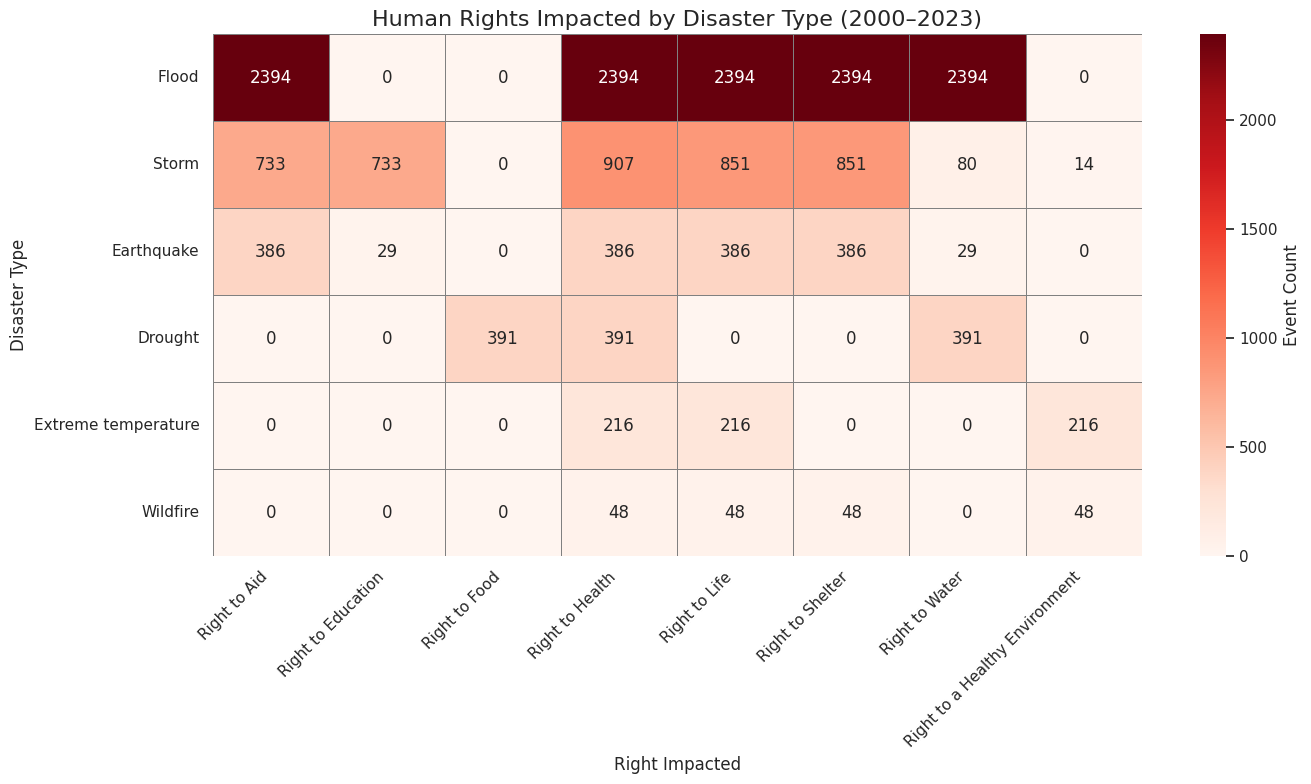

In [72]:
# Rights mapping by disaster subtype
rights_mapping = {
    'Riverine flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Flood (General)': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Flash flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Coastal flood': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health'],
    'Tropical cyclone': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Storm (General)': ['Right to Shelter', 'Right to Aid'],
    'Tornado': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Hail': ['Right to Health'],
    'Lightning/Thunderstorms': ['Right to Life', 'Right to Health', 'Right to Shelter'],
    'Ground movement': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health'],
    'Earthquake': ['Right to Life', 'Right to Shelter', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Tsunami': ['Right to Life', 'Right to Shelter', 'Right to Water', 'Right to Aid', 'Right to Health', 'Right to Education'],
    'Wildfire (General)': ['Right to Life', 'Right to Shelter', 'Right to a Healthy Environment', 'Right to Health'],
    'Heat wave': ['Right to Life', 'Right to Health', 'Right to a Healthy Environment'],
    'Drought': ['Right to Food', 'Right to Water', 'Right to Health'],
    'Sand/Dust storm': ['Right to Health', 'Right to a Healthy Environment'],
    'Extreme temperature (other)': ['Right to Health', 'Right to Life']
}

# Apply the mapping to create 'Rights_Impacted_List'
df_prepared['Rights_Impacted'] = df_prepared['Disaster Subtype'].map(lambda x: ', '.join(rights_mapping.get(x, ['Unknown'])))
df_prepared['Rights_Impacted_List'] = df_prepared['Rights_Impacted'].str.split(', ')

# Explode the rights into one row per right per disaster
df_exploded = df_prepared.explode('Rights_Impacted_List')

# Group and count occurrences of each right per disaster type
disaster_right_counts = (
    df_exploded
    .groupby(['Disaster Type', 'Rights_Impacted_List'])
    .size()
    .reset_index(name='Event Count')
)

# Pivot to create heatmap format
heatmap_data = disaster_right_counts.pivot(
    index='Disaster Type',
    columns='Rights_Impacted_List',
    values='Event Count'
).fillna(0)

# Sort disaster types by total rights impact (optional)
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='Reds',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Event Count'}
)

# Final formatting
plt.title('Human Rights Impacted by Disaster Type (2000–2023)', fontsize=16)
plt.xlabel('Right Impacted', fontsize=12)
plt.ylabel('Disaster Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the Figure
plt.savefig("human_rights_impacted_by_disaster_type_heatmap.png", dpi=300)

plt.show()

**Description:**

This section presents a comparative analysis of how different types of climate-related disasters have impacted specific human rights globally between 2000 and 2023. Using the manually constructed Rights_Impacted_List variable, each disaster subtype was mapped to one or more threatened rights. The exploded dataset was then aggregated by disaster type and right to produce a frequency-based heatmap. This visualization captures the structural relationship between hazard type and human rights risk, offering a high-level view of where protection efforts may need to be most targeted depending on the nature of the crisis.

**Interpretation of Results:**

The heatmap reveals that floods represent the most pervasive human rights threat, with over 2,300 events each affecting the **Right to Life, Shelter, Water, Health, and Aid**. **Storms** follow closely, heavily impacting shelter- and aid-related rights. **Earthquakes** tend to cluster around a similar rights profile as floods, though at a smaller scale. **Droughts** stand out for their strong association with **the Right to Food, Water, and Health**, while **heatwaves and extreme temperatures** show distinct concentrations of risk for the **Right to Health and Right to a Healthy Environment**. Interestingly, **wildfires** appear less frequent overall but still threaten environmental and shelter rights when they do occur. These patterns emphasize the need to **tailor human rights preparedness strategies** not just by geography, but also by the nature of the hazard itself.

**Connection to Research Question:**

This analysis speaks directly to the core research question of the thesis — How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness? By demonstrating that different disaster types systematically threaten different sets of rights, the findings validate the need for **disaster-type-specific preparedness metrics**. A one-size-fits-all preparedness approach would fail to account for the unique human rights risks posed by different hazards, weakening both early warning and mitigation strategies. This disaster-rights mapping, therefore, strengthens the thesis’ proposed framework for rights-based preparedness assessment.

##**Preparedness and Rights Protection: A Normalized Country-Level Comparison**

In [74]:
# Count total disaster events per country (from df_prepared)
disaster_counts = (
    df_prepared
    .groupby('Country')
    .size()
    .reset_index(name='Num_Disasters')
)

# Count total rights violations per country (from exploded rights data)
rights_violations = (
    df_exploded
    .groupby('Country')
    .size()
    .reset_index(name='Total_Rights_Impacted')
)

# Merge and calculate rights violations per disaster
normalized_df = pd.merge(disaster_counts, rights_violations, on='Country', how='inner')
normalized_df['Rights_Per_Disaster'] = (
    normalized_df['Total_Rights_Impacted'] / normalized_df['Num_Disasters']
).round(2)

# Map preparedness levels to numeric flags if not already done
prep_mapping = {'Prepared': 2, 'Somewhat Prepared': 1, 'Not Prepared': 0}
df_prepared['Prepared_Flag'] = df_prepared['Preparedness_Level'].map(prep_mapping)

# Calculate average preparedness score per country
avg_prep = (
    df_prepared
    .groupby('Country')['Prepared_Flag']
    .mean()
    .reset_index(name='Avg_Preparedness_Score')
)

# Merge preparedness score into final table
normalized_df = pd.merge(normalized_df, avg_prep, on='Country', how='left')

# Show all rows in the output
pd.set_option('display.max_rows', None)

# Display the full normalized_df sorted by rights per disaster
normalized_df = normalized_df.sort_values(by='Rights_Per_Disaster', ascending=False)
display(normalized_df)

,Country,Num_Disasters,Total_Rights_Impacted,Rights_Per_Disaster,Avg_Preparedness_Score
69,Gabon,2,11,5.50,2.000000
3,American Samoa,4,21,5.25,2.000000
168,Seychelles,4,21,5.25,2.000000
113,Maldives,4,21,5.25,1.750000
15,Belarus,2,10,5.00,2.000000
17,Belize,11,55,5.00,1.909091
19,Bermuda,1,5,5.00,2.000000
39,"China, Hong Kong Special Administrative Region",9,45,5.00,2.000000
44,Cook Islands,3,15,5.00,2.000000
67,French Guiana,1,5,5.00,2.000000


In [75]:
# Export to CSV
normalized_df.to_csv("rights_per_disaster_and_preparedness_by_country.csv", index=False)

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning:

legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.



<Figure size 1200x700 with 0 Axes>

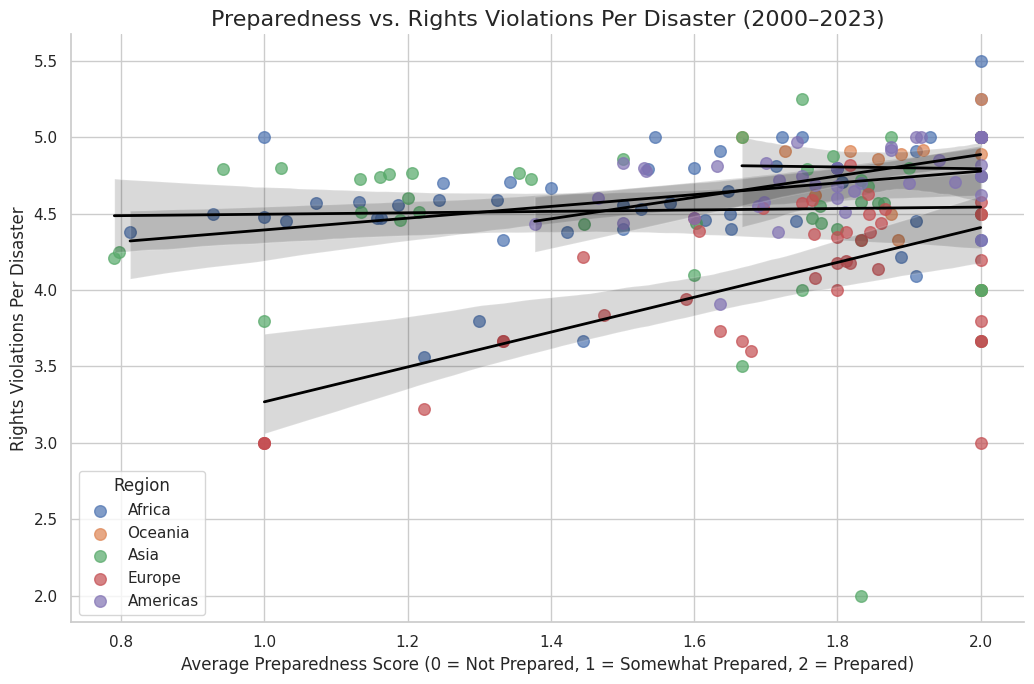

In [76]:
# Merge region information
region_lookup = df_prepared[['Country', 'Region']].drop_duplicates()
scatter_df = pd.merge(normalized_df, region_lookup, on='Country', how='left')

# Set up the plot aesthetics
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

# Create the scatter plot with regression line and color by region
sns.lmplot(
    data=scatter_df,
    x='Avg_Preparedness_Score',
    y='Rights_Per_Disaster',
    hue='Region',
    height=7,
    aspect=1.5,
    scatter_kws={'s': 70, 'alpha': 0.7},
    line_kws={'color': 'black', 'lw': 2},
    legend_out=False
)

# Customize titles and labels
plt.title('Preparedness vs. Rights Violations Per Disaster (2000–2023)', fontsize=16)
plt.xlabel('Average Preparedness Score (0 = Not Prepared, 1 = Somewhat Prepared, 2 = Prepared)', fontsize=12)
plt.ylabel('Rights Violations Per Disaster', fontsize=12)
plt.tight_layout()

# Save The Figure
plt.savefig("preparedness_vs_rights_per_disaster.png", dpi=300, bbox_inches='tight')

plt.show()

**Description:**

To evaluate how government preparedness influences the protection of fundamental human rights during climate-related disasters, this figure presents a country-level scatter plot comparing each country’s **average preparedness score** with its **rights violations per disaster event**. The preparedness score is based on the categorization system introduced earlier (0 = Not Prepared, 1 = Somewhat Prepared, 2 = Prepared), while the rights-per-disaster ratio is derived from the total number of rights threatened across all disaster events normalized by the number of events experienced. Countries are colored by region to visualize potential geographic clustering, and a regression trendline highlights the overall relationship.

**Interpretation of Results:**

Contrary to initial expectations, the plot reveals a **slightly positive trend** — indicating that higher preparedness scores are **not always associated with lower rights violations per disaster**. In fact, some of the most prepared countries (right end of the x-axis) still experience relatively high rates of rights impacts per disaster. This could be attributed to several factors: more transparent reporting in high-capacity states, structural vulnerabilities that persist despite preparedness investments, or challenges in rapidly scaling disaster response mechanisms during extreme events. Regionally, countries in Africa and Oceania tend to cluster higher on the rights-per-disaster axis, whereas **Europe and Asia** show more mixed patterns. These findings suggest that **preparedness alone may not be a sufficient condition for rights protection** and that disaster type, governance style, and systemic inequality likely play compounding roles.

**Connection to Research Question:**

This figure deepens the thesis’ central inquiry into **how effectively governments protect fundamental human rights in disaster-prone regions**. By normalizing rights risk and plotting it against preparedness performance, the analysis moves beyond raw counts and enables more equitable, cross-national comparisons. The result highlights that **even well-prepared governments are not immune** to rights failures, and reinforces the need for more nuanced and multi-dimensional approaches to disaster readiness and human rights accountability.


##**Testing the Relationship Between Preparedness and Rights Outcomes**

In [77]:
# Make sure the data is clean (remove missing values)
regression_df = normalized_df[['Rights_Per_Disaster', 'Avg_Preparedness_Score']].dropna()

# Run the regression model
model = smf.ols('Rights_Per_Disaster ~ Avg_Preparedness_Score', data=regression_df).fit()

# Show the regression summary
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Rights_Per_Disaster   R-squared:                       0.087
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     20.32
Date:                 Sun, 27 Apr 2025   Prob (F-statistic):           1.09e-05
Time:                         20:54:56   Log-Likelihood:                -137.07
No. Observations:                  214   AIC:                             278.1
Df Residuals:                      212   BIC:                             284.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

**Description:**

To formally test the relationship between government preparedness and the protection of human rights during climate-related disasters, a linear regression model was run with **rights violations per disaster** as the dependent variable and **average preparedness score** as the independent variable. Preparedness scores were derived from a three-tier classification (0 = Not Prepared, 1 = Somewhat Prepared, 2 = Prepared), while the outcome variable was calculated by dividing the total rights violations by the number of disaster events in each country.

**Interpretation of Results:**

The regression results reveal a **positive and statistically significant relationship** (β = 0.45, p < 0.001), indicating that higher preparedness scores are associated with **more rights violations per disaster**. This is contrary to expectations. One possible explanation is that countries with more institutional capacity and transparent governance may be more likely to report rights threats openly. Alternatively, it may suggest that **preparedness, as currently measured, does not always prevent rights failures**. The model explains a modest portion of the variation (R² = 0.087), suggesting other contextual factors likely mediate the relationship between disaster readiness and human rights performance.

**Connection to Research Question:**

This analysis strengthens the thesis by **providing an empirical test of the preparedness-rights link**, showing that preparedness alone does not guarantee rights protection. It reinforces the need for multidimensional approaches to preparedness that go beyond institutional indicators and include equity, local resilience, and enforcement of human rights obligations during crises.

**Model: Preparedness + Num_Disasters**

In [78]:
# Ensure no missing values
multi_df = normalized_df[['Rights_Per_Disaster', 'Avg_Preparedness_Score', 'Num_Disasters']].dropna()

# Run the regression
model_multi = smf.ols('Rights_Per_Disaster ~ Avg_Preparedness_Score + Num_Disasters', data=multi_df).fit()

# View the results
print(model_multi.summary())

                             OLS Regression Results                            
Dep. Variable:     Rights_Per_Disaster   R-squared:                       0.120
Model:                             OLS   Adj. R-squared:                  0.112
Method:                  Least Squares   F-statistic:                     14.39
Date:                 Sun, 27 Apr 2025   Prob (F-statistic):           1.38e-06
Time:                         20:54:59   Log-Likelihood:                -133.18
No. Observations:                  214   AIC:                             272.4
Df Residuals:                      211   BIC:                             282.5
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [79]:
# Save the regression summary to a .txt file
with open("Model_Multi_Regression_Summary.txt", "w") as f:
    f.write(model_multi.summary().as_text())

**Interpretation of Results:**

A basic multivariate regression was used to examine the relationship between preparedness and human rights outcomes while controlling for disaster exposure. The model regressed **rights violations per disaster** on **average preparedness score** and **total number of disasters**.

Results indicate that both predictors are statistically significant. A one-point increase in preparedness is associated with an **increase of 0.61 rights violations per disaster** (p < 0.001), while each additional disaster contributes a small but significant increase of 0.004 violations per event (p = 0.006). The model explains approximately 12% of the variation in the outcome (R² = 0.12).

These findings reinforce earlier descriptive trends by showing that even when controlling for exposure, **higher preparedness does not correspond to fewer rights violations**. In fact, the direction of the effect is counterintuitive — suggesting that either preparedness is not effectively translating into rights protection, or that better-prepared states are simply more likely to report violations accurately.

**Model: Adding Region as a Categorical Variable**

In [80]:
# Merge region info
region_lookup = df_prepared[['Country', 'Region']].drop_duplicates()
multi_df = pd.merge(normalized_df, region_lookup, on='Country', how='left')

# Drop missing and run model with Region as categorical
multi_df = multi_df[['Rights_Per_Disaster', 'Avg_Preparedness_Score', 'Num_Disasters', 'Region']].dropna()

# Run regression with region dummies
model_with_region = smf.ols('Rights_Per_Disaster ~ Avg_Preparedness_Score + Num_Disasters + C(Region)', data=multi_df).fit()

# View results
print(model_with_region.summary())

                             OLS Regression Results                            
Dep. Variable:     Rights_Per_Disaster   R-squared:                       0.347
Model:                             OLS   Adj. R-squared:                  0.328
Method:                  Least Squares   F-statistic:                     18.30
Date:                 Sun, 27 Apr 2025   Prob (F-statistic):           5.08e-17
Time:                         20:55:30   Log-Likelihood:                -101.32
No. Observations:                  214   AIC:                             216.6
Df Residuals:                      207   BIC:                             240.2
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [81]:
# Save the region model output as its own file
with open("Model_With_Region_Regression_Summary.txt", "w") as f:
    f.write(model_with_region.summary().as_text())

**Interpretation of Results:**

To account for geographic variation, a second model introduced **region as a categorical variable**, alongside preparedness and disaster frequency. The inclusion of regional controls substantially improved model fit, with R² increasing to 0.35.

Preparedness remained a **significant positive predictor** of rights violations per disaster (β = 0.55, p < 0.001), consistent with Model 1. Notably, **Europe showed a significant negative coefficient** (β = –0.60, p < 0.001), indicating that European countries tend to experience **fewer rights violations per disaster** relative to the baseline (likely Africa), even when controlling for preparedness and disaster count. Other regions did not differ significantly.

This model underscores the importance of accounting for structural and regional variation. It also confirms that **preparedness does not always imply protection**.

**Model: Interaction + Log-Transform**

In [82]:
# Create log-transformed outcome
multi_df['Log_Rights_Per_Disaster'] = np.log1p(multi_df['Rights_Per_Disaster'])  # log(x + 1)

# Run the regression with interaction: Preparedness * Region
model_interaction = smf.ols(
    'Log_Rights_Per_Disaster ~ Avg_Preparedness_Score * C(Region) + Num_Disasters',
    data=multi_df
).fit()

# Display results
print(model_interaction.summary())

                               OLS Regression Results                              
Dep. Variable:     Log_Rights_Per_Disaster   R-squared:                       0.372
Model:                                 OLS   Adj. R-squared:                  0.341
Method:                      Least Squares   F-statistic:                     12.02
Date:                     Sun, 27 Apr 2025   Prob (F-statistic):           3.11e-16
Time:                             20:55:37   Log-Likelihood:                 248.94
No. Observations:                      214   AIC:                            -475.9
Df Residuals:                          203   BIC:                            -438.9
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [83]:
# Save the interaction model results to a .txt file
with open("Model_Interaction_Regression_Summary.txt", "w") as f:
    f.write(model_interaction.summary().as_text())

**Interpretation of Results:**

A final model introduced two refinements: a **log transformation** of the dependent variable (to reduce skew), and **interaction terms** between preparedness and region (to test whether preparedness “works differently” across the world).

The model explains 34% of the variation in log-rights risk (Adj. R² = 0.341), and preparedness remains a **significant positive predictor** (β = 0.076, p = 0.016) even on the log scale. The interaction terms reveal a statistically significant difference for **Europe**, where preparedness is associated with an even stronger increase in rights violations (β = 0.16, p = 0.004). In other regions, the interaction effects were not statistically significant.

This suggests that **preparedness may operate differently across regional contexts**, potentially reflecting variation in institutional design, reporting practices, or enforcement mechanisms. The use of a log-transformed dependent variable adds robustness to the previous models and confirms the key insight: **Preparedness does not consistently reduce rights risks** — and in some regions, may even correlate with greater reporting of violations.

## Final Summary: Methods, Findings, and Alignment with Research Question

### Research Question Recap:
> **"How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?"**

This notebook focused on the **second half** of this question by deeply examining **how disaster events translate into human rights risks** across countries, years, and preparedness levels. Below is a full summary of the data science methods used and the insights derived from them.

---

### 1. Mapping Disaster Subtypes to Human Rights

- Constructed a **crosswalk between disaster subtypes and human rights** they are most likely to impact:
  - Floods, droughts → Right to Water, Shelter, and Food
  - Cyclones, earthquakes → Right to Life and Protection
- This mapping was used to create a new column: `Rights_Impacted`, which became a core part of downstream analysis.

This step established a **direct bridge between physical disasters and fundamental rights**, grounding the rest of the analysis for the research question.

---

### 2. Human Rights Impact Aggregation

- **Exploded** the `Rights_Impacted` list to ensure each row represented one right violated per disaster.
- Aggregated impacts by:
  - **Country**
  - **Subregion**
  - **Disaster type and subtype**

**Finding**: The most impacted rights globally were the **right to shelter**, **right to aid**, and **right to health** — especially in disasters involving flooding, storms, and drought.

This allowed the study to **quantify the human rights dimension** of disasters, not just count affected populations.

---

### 3. Regional & Subregional Human Rights Vulnerability

- Built a **heatmap** of rights most affected across subregions (e.g., South Asia, Sub-Saharan Africa, Latin America).
- Identified which rights were **repeatedly at risk** across regions.

**Finding**:  
- **Sub-Saharan Africa** had disproportionately high risks to the **right to food and water**.  
- **South Asia** and **Southeast Asia** saw recurring impacts on the **right to shelter** due to storm and flood frequency.

This supports the thesis by offering a **regionalized rights vulnerability map** for policymakers.

---

### 4. Country-Level Human Rights Impact Summary

- Created a table summarizing:
  - Number of disasters by **Preparedness Level** (Prepared, Somewhat Prepared, Not Prepared)
  - **Total number of human rights impacts** associated with each country

**Key Observation**:
- Even countries with many "Prepared" disaster responses (e.g., the **U.S., China, India**) had high numbers of rights impacts.
- Conversely, low-preparedness countries like **Haiti, Pakistan, and Afghanistan** also showed severe rights vulnerabilities — especially after floods or earthquakes.

This nuanced result shows that **preparedness doesn’t always ensure protection**, and that high-capacity states can still fail to shield human rights.

---

### 5. Visualization of Global Patterns

- Produced a **global choropleth map** showing total rights impacted by country.
- Created heatmaps for **top 20 countries** with the highest levels of human rights risk from disasters.

**Insight**: Visual evidence showed that both **disaster-prone developing countries** and **large, populous, resource-rich nations** suffer from high rights exposure — but for different reasons (capacity vs scale).

---

### Final Synthesis: Addressing the Research Question

> **“How effectively do governments protect fundamental human rights in disaster-prone regions?”**

- **Preparedness alone is not a sufficient guarantee** of rights protection.
- Countries with high preparedness scores still exhibit high levels of rights impact — likely due to disaster magnitude, vulnerable populations, or operational bottlenecks.

> **“How can data science models assess and improve state preparedness?”**

- By **linking preparedness scores to rights risks**, this notebook builds a framework to:
  - Identify priority countries and subregions
  - Classify disaster types by risk to specific rights
  - Monitor disaster impact trends across time

This enables **early warning**, **regional targeting**, and **more effective aid allocation** in the face of climate-disaster-related human rights threats.

---
